In [1]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 300

In [2]:
## Name model, and load and preprocess dataset

In [3]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "UNet_Chunks_21Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [4]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec.npy')
spectra100 = np.load('Dataset21_100MHz_Spec.npy')
conc1 = np.load('Dataset21_Conc.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
#RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
#RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
#RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
#RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [4]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
#RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)   # These spectra are the representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#spectraVal400 = torch.tensor(spectraVal400).float().to(device)
#RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 32, shuffle=True)

In [7]:
del X_train
del X_test
del y_train
del y_test

In [8]:
'''
class UNetChunks(nn.Module):
    def __init__(self):
        super(UNetChunks, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder3 = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 1, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        chunks = []
        chunk_size = 4600  # Adjust as needed
        for i in range(0, x.size(2), chunk_size):
            chunk = x[:, :, i:i+chunk_size]
            x1 = self.encoder1(chunk)
            x2 = self.encoder2(x1)
            x3 = self.decoder2(x2)
            x4 = self.decoder1(x3 + x1)
            chunks.append(x4)
        return torch.cat(chunks, dim=2)
'''

'\nclass UNetChunks(nn.Module):\n    def __init__(self):\n        super(UNetChunks, self).__init__()\n\n        self.encoder1 = nn.Sequential(\n            nn.Conv1d(1, 16, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv1d(16, 32, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True)\n        )\n        self.encoder2 = nn.Sequential(\n            nn.Conv1d(32, 64, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv1d(64, 128, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True)\n        )\n        self.encoder3 = nn.Sequential(\n            nn.Conv1d(128, 256, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.Conv1d(256, 512, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True)\n        )\n\n        self.decoder3 = nn.Sequential(\n            nn.ConvTranspose1d(512, 256, kernel_size=3, padding=1),\n            nn.ReLU(inplace=True),\n            nn.ConvTranspose1d(

In [5]:
class UNetChunks(nn.Module):
    def __init__(self):
        super(UNetChunks, self).__init__()

        self.encoder1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(16, 1, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        chunks = []
        chunk_size = 4600  # Adjust as needed
        for i in range(0, x.size(2), chunk_size):
            chunk = x[:, :, i:i+chunk_size]
            x1 = self.encoder1(chunk)
            x2 = self.encoder2(x1)
            x3 = self.decoder2(x2)
            x4 = self.decoder1(x3 + x1)
            chunks.append(x4)
        return torch.cat(chunks, dim=2)

In [10]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 25  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        
         # Instantiate the GradScaler
        scaler = GradScaler()
        for inputs, labels in train_loader:
            # Move data to GPU
             inputs, labels = inputs.to(device), labels.to(device)
             inputs = inputs.unsqueeze(1)
             labels = labels.unsqueeze(1)
            # Zero the parameter gradients
             optimizer.zero_grad()
            # Enable autocasting for forward and backward passes
             with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
             train_loss += loss.item() * inputs.size(0)
             # Scale the loss and perform backpropagation
             scaler.scale(loss).backward()
             # Step the optimizer
             scaler.step(optimizer)
              # Update the scaler
             scaler.update()
        train_losses.append(train_loss)

        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.unsqueeze(1)
                labels = labels.unsqueeze(1)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [11]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = UNetChunks()

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params3.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/300], Train Loss: 3.2843, Test Loss: 0.5603
Epoch time:  36.49903583526611
Epoch [2/300], Train Loss: 2.0700, Test Loss: 0.4989
Epoch time:  35.02935528755188
Epoch [3/300], Train Loss: 1.9830, Test Loss: 0.4944
Epoch time:  35.10135555267334
Epoch [4/300], Train Loss: 1.9761, Test Loss: 0.5040
Epoch time:  35.10877346992493
Epoch [5/300], Train Loss: 1.9823, Test Loss: 0.4930
Epoch time:  35.13020324707031
Epoch [6/300], Train Loss: 1.9778, Test Loss: 0.4922
Epoch time:  35.13237977027893
Epoch [7/300], Train Loss: 1.9734, Test Loss: 0.4899
Epoch time:  35.12152576446533
Epoch [8/300], Train Loss: 1.9766, Test Loss: 0.4905
Epoch time:  35.11002445220947
Epoch [9/300], Train Loss: 1.9631, Test Loss: 0.4898
Epoch time:  35.133533000946045
Epoch [10/300], Train Loss: 2.0171, Test Loss: 0.4903
Epoch time:  35.09705138206482
Epoch [11/300], Train Loss: 1.9571, Test Loss: 0.4884
Epoch time:  35.087475299835205
Epoch [12/300], Train 

Epoch [97/300], Train Loss: 1.7332, Test Loss: 0.4348
Epoch time:  35.02226209640503
Epoch [98/300], Train Loss: 1.7362, Test Loss: 0.4340
Epoch time:  35.02169919013977
Epoch [99/300], Train Loss: 1.7338, Test Loss: 0.4331
Epoch time:  35.0209755897522
Epoch [100/300], Train Loss: 1.7327, Test Loss: 0.4341
Epoch time:  35.012948751449585
Epoch [101/300], Train Loss: 1.7330, Test Loss: 0.4321
Epoch time:  35.01922655105591
Epoch [102/300], Train Loss: 1.7290, Test Loss: 0.4345
Epoch time:  35.026092290878296
Epoch [103/300], Train Loss: 1.7295, Test Loss: 0.4353
Epoch time:  35.02151370048523
Epoch [104/300], Train Loss: 1.7325, Test Loss: 0.4306
Epoch time:  35.05575203895569
Epoch [105/300], Train Loss: 1.7264, Test Loss: 0.4330
Epoch time:  34.99728846549988
Epoch [106/300], Train Loss: 1.7278, Test Loss: 0.4306
Epoch time:  35.00283622741699
Epoch [107/300], Train Loss: 1.7262, Test Loss: 0.4298
Epoch time:  34.99824380874634
Epoch [108/300], Train Loss: 1.7254, Test Loss: 0.4291
E

Epoch [193/300], Train Loss: 1.6846, Test Loss: 0.4254
Epoch time:  34.96100163459778
Epoch [194/300], Train Loss: 1.6859, Test Loss: 0.4209
Epoch time:  34.957637548446655
Epoch [195/300], Train Loss: 1.6853, Test Loss: 0.4215
Epoch time:  34.953505754470825
Epoch [196/300], Train Loss: 1.6848, Test Loss: 0.4235
Epoch time:  34.96194648742676
Epoch [197/300], Train Loss: 1.6838, Test Loss: 0.4224
Epoch time:  34.974095821380615
Epoch [198/300], Train Loss: 1.6845, Test Loss: 0.4218
Epoch time:  34.97775983810425
Epoch [199/300], Train Loss: 1.6847, Test Loss: 0.4226
Epoch time:  34.98026394844055
Epoch [200/300], Train Loss: 1.6866, Test Loss: 0.4243
Epoch time:  34.9688355922699
Epoch [201/300], Train Loss: 1.6808, Test Loss: 0.4200
Epoch time:  35.008785247802734
Epoch [202/300], Train Loss: 1.6836, Test Loss: 0.4212
Epoch time:  34.97800040245056
Epoch [203/300], Train Loss: 1.6837, Test Loss: 0.4250
Epoch time:  34.97379207611084
Epoch [204/300], Train Loss: 1.6841, Test Loss: 0.4

Epoch [289/300], Train Loss: 1.6586, Test Loss: 0.4122
Epoch time:  34.994773387908936
Epoch [290/300], Train Loss: 1.6553, Test Loss: 0.4165
Epoch time:  34.977431297302246
Epoch [291/300], Train Loss: 1.6552, Test Loss: 0.4147
Epoch time:  34.98558592796326
Epoch [292/300], Train Loss: 1.6583, Test Loss: 0.4152
Epoch time:  34.98799729347229
Epoch [293/300], Train Loss: 1.6541, Test Loss: 0.4127
Epoch time:  34.987762451171875
Epoch [294/300], Train Loss: 1.6518, Test Loss: 0.4118
Epoch time:  35.023170709609985
Epoch [295/300], Train Loss: 1.6548, Test Loss: 0.4152
Epoch time:  34.97774791717529
Epoch [296/300], Train Loss: 1.6545, Test Loss: 0.4115
Epoch time:  34.987313747406006
Epoch [297/300], Train Loss: 1.6514, Test Loss: 0.4165
Epoch time:  34.97111439704895
Epoch [298/300], Train Loss: 1.6544, Test Loss: 0.4124
Epoch time:  34.97729969024658
Epoch [299/300], Train Loss: 1.6530, Test Loss: 0.4139
Epoch time:  34.97031927108765
Epoch [300/300], Train Loss: 1.6547, Test Loss: 0

In [6]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)

In [7]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params3.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = UNetChunks()

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

UNetChunks(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (decoder2): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU(inplace=True)
  )
  (decoder1): Sequential(
    (0): ConvTranspose1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): ConvTranspose1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)

In [10]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100].unsqueeze(1))  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print RMSE
print('model err: ', mse)  # Print RMSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

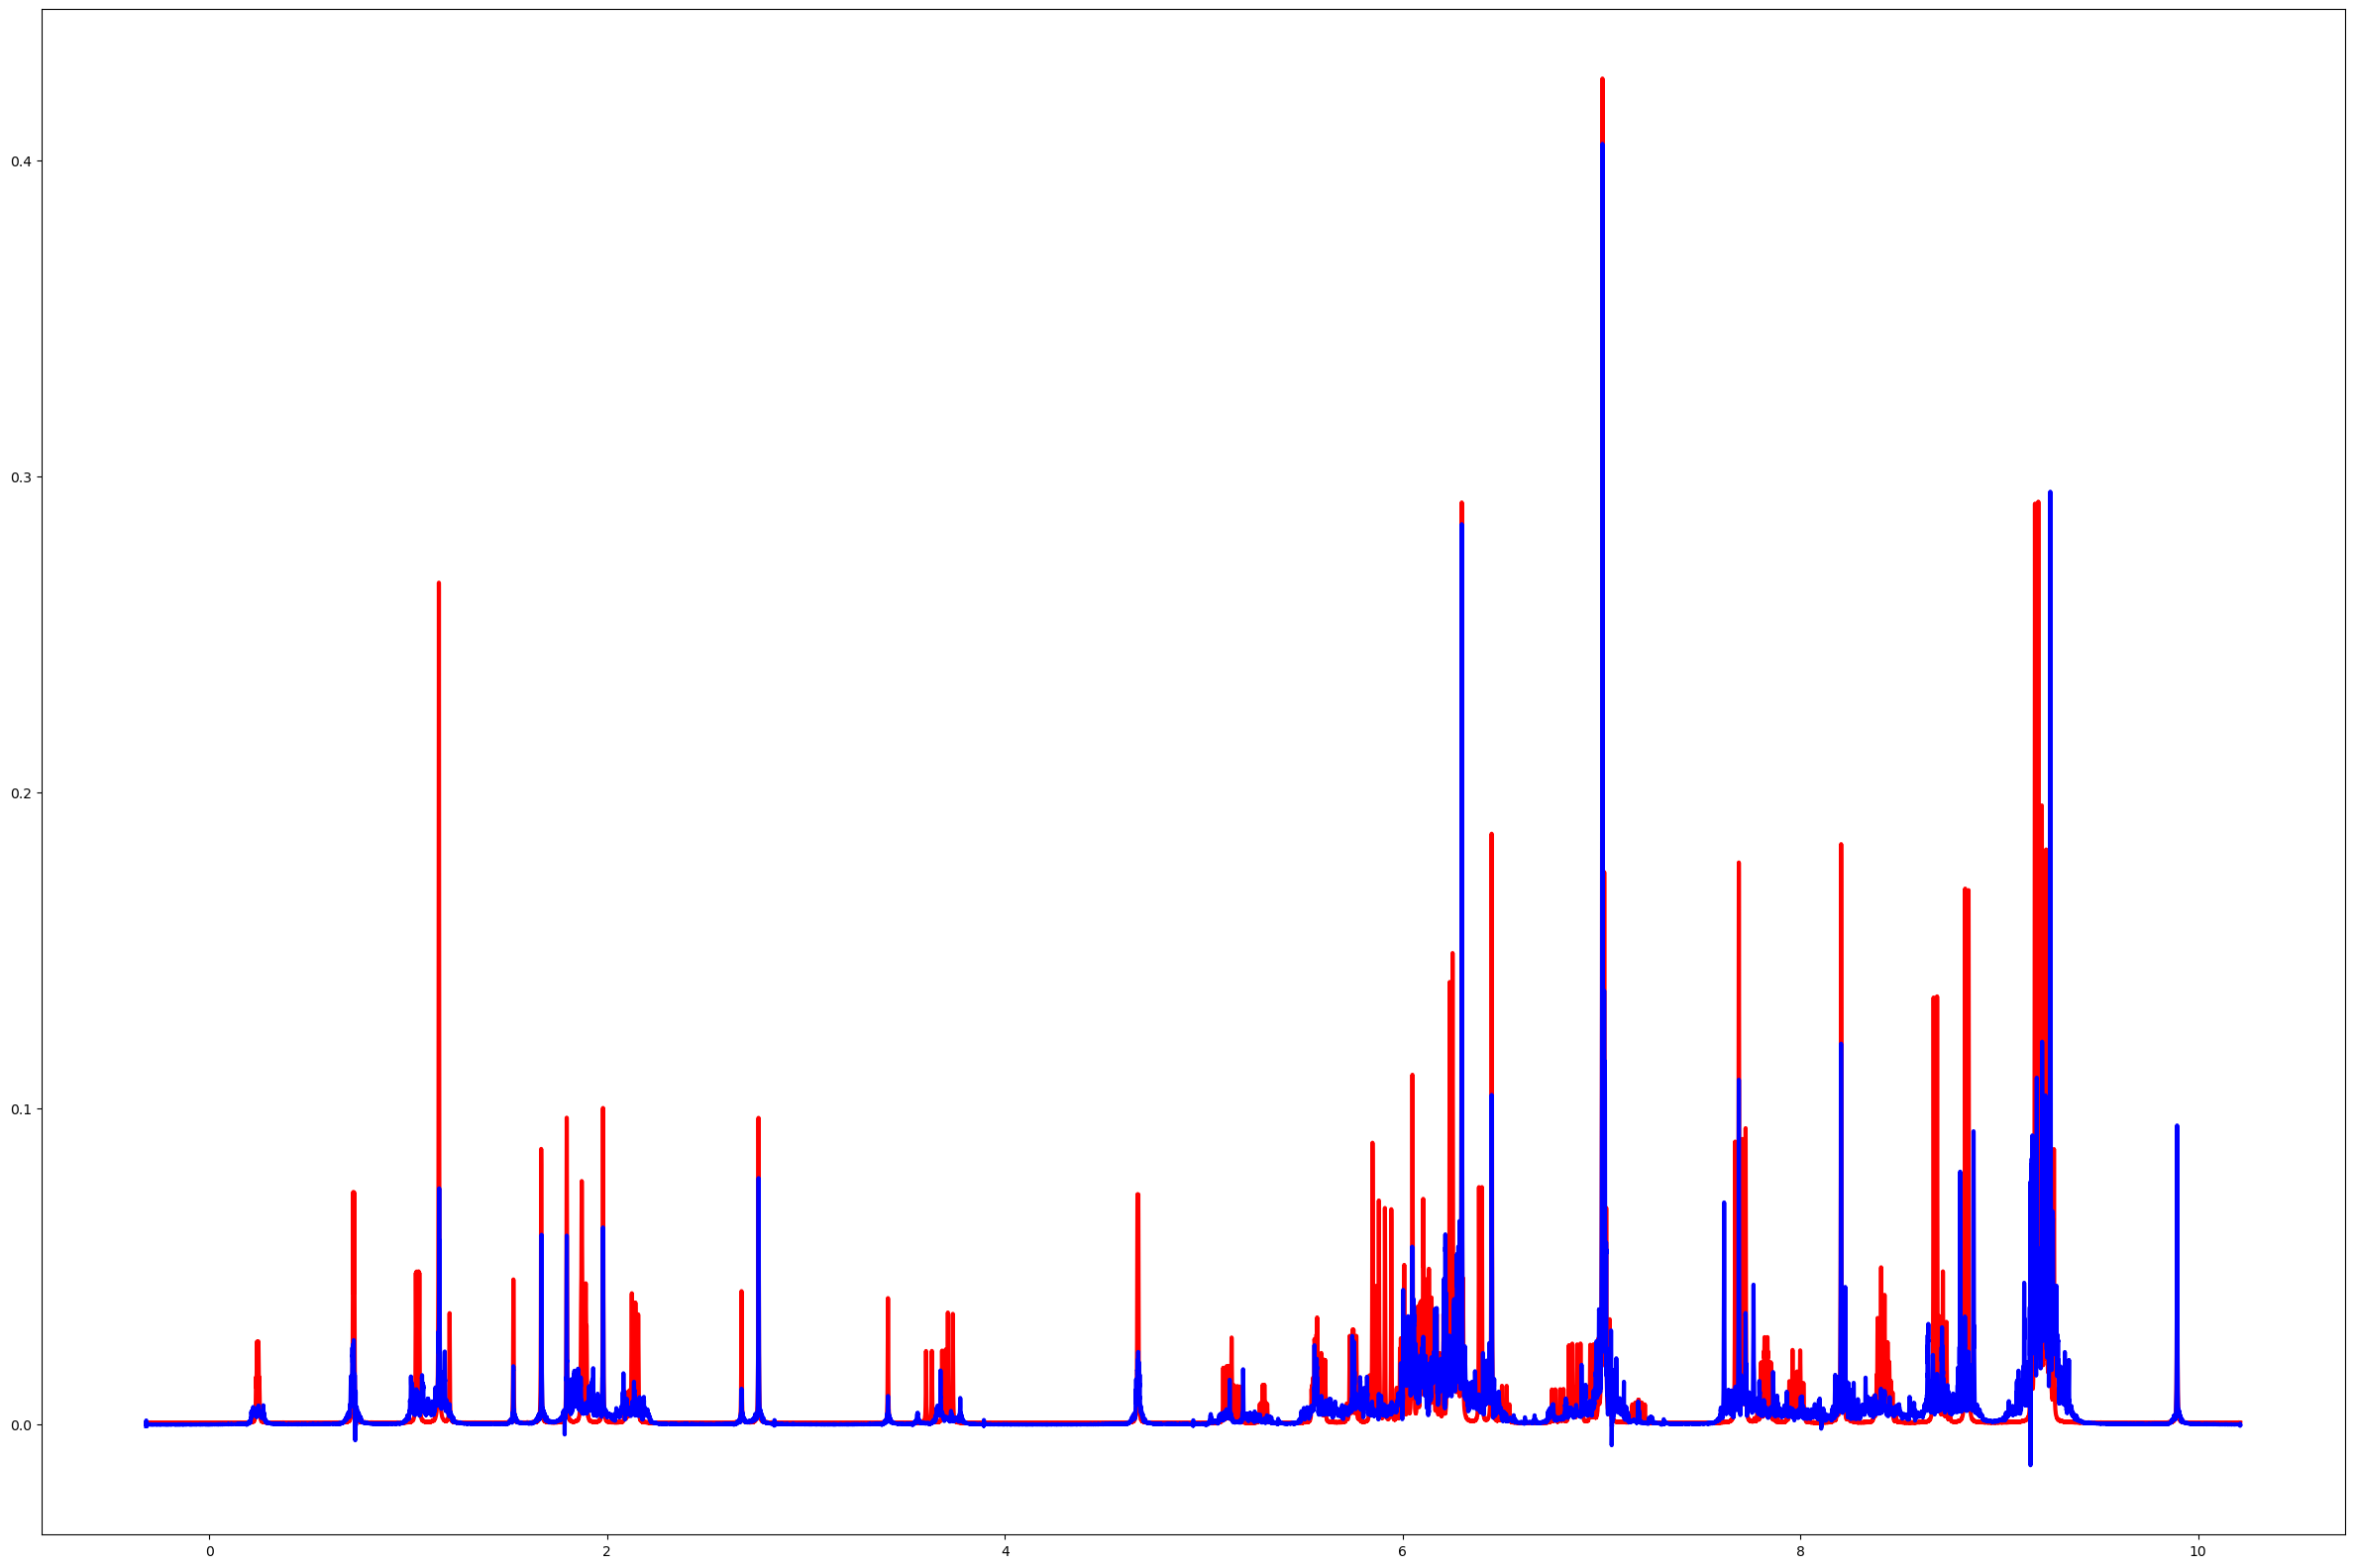

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46000])) that is different to the input size (torch.Size([1, 46000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


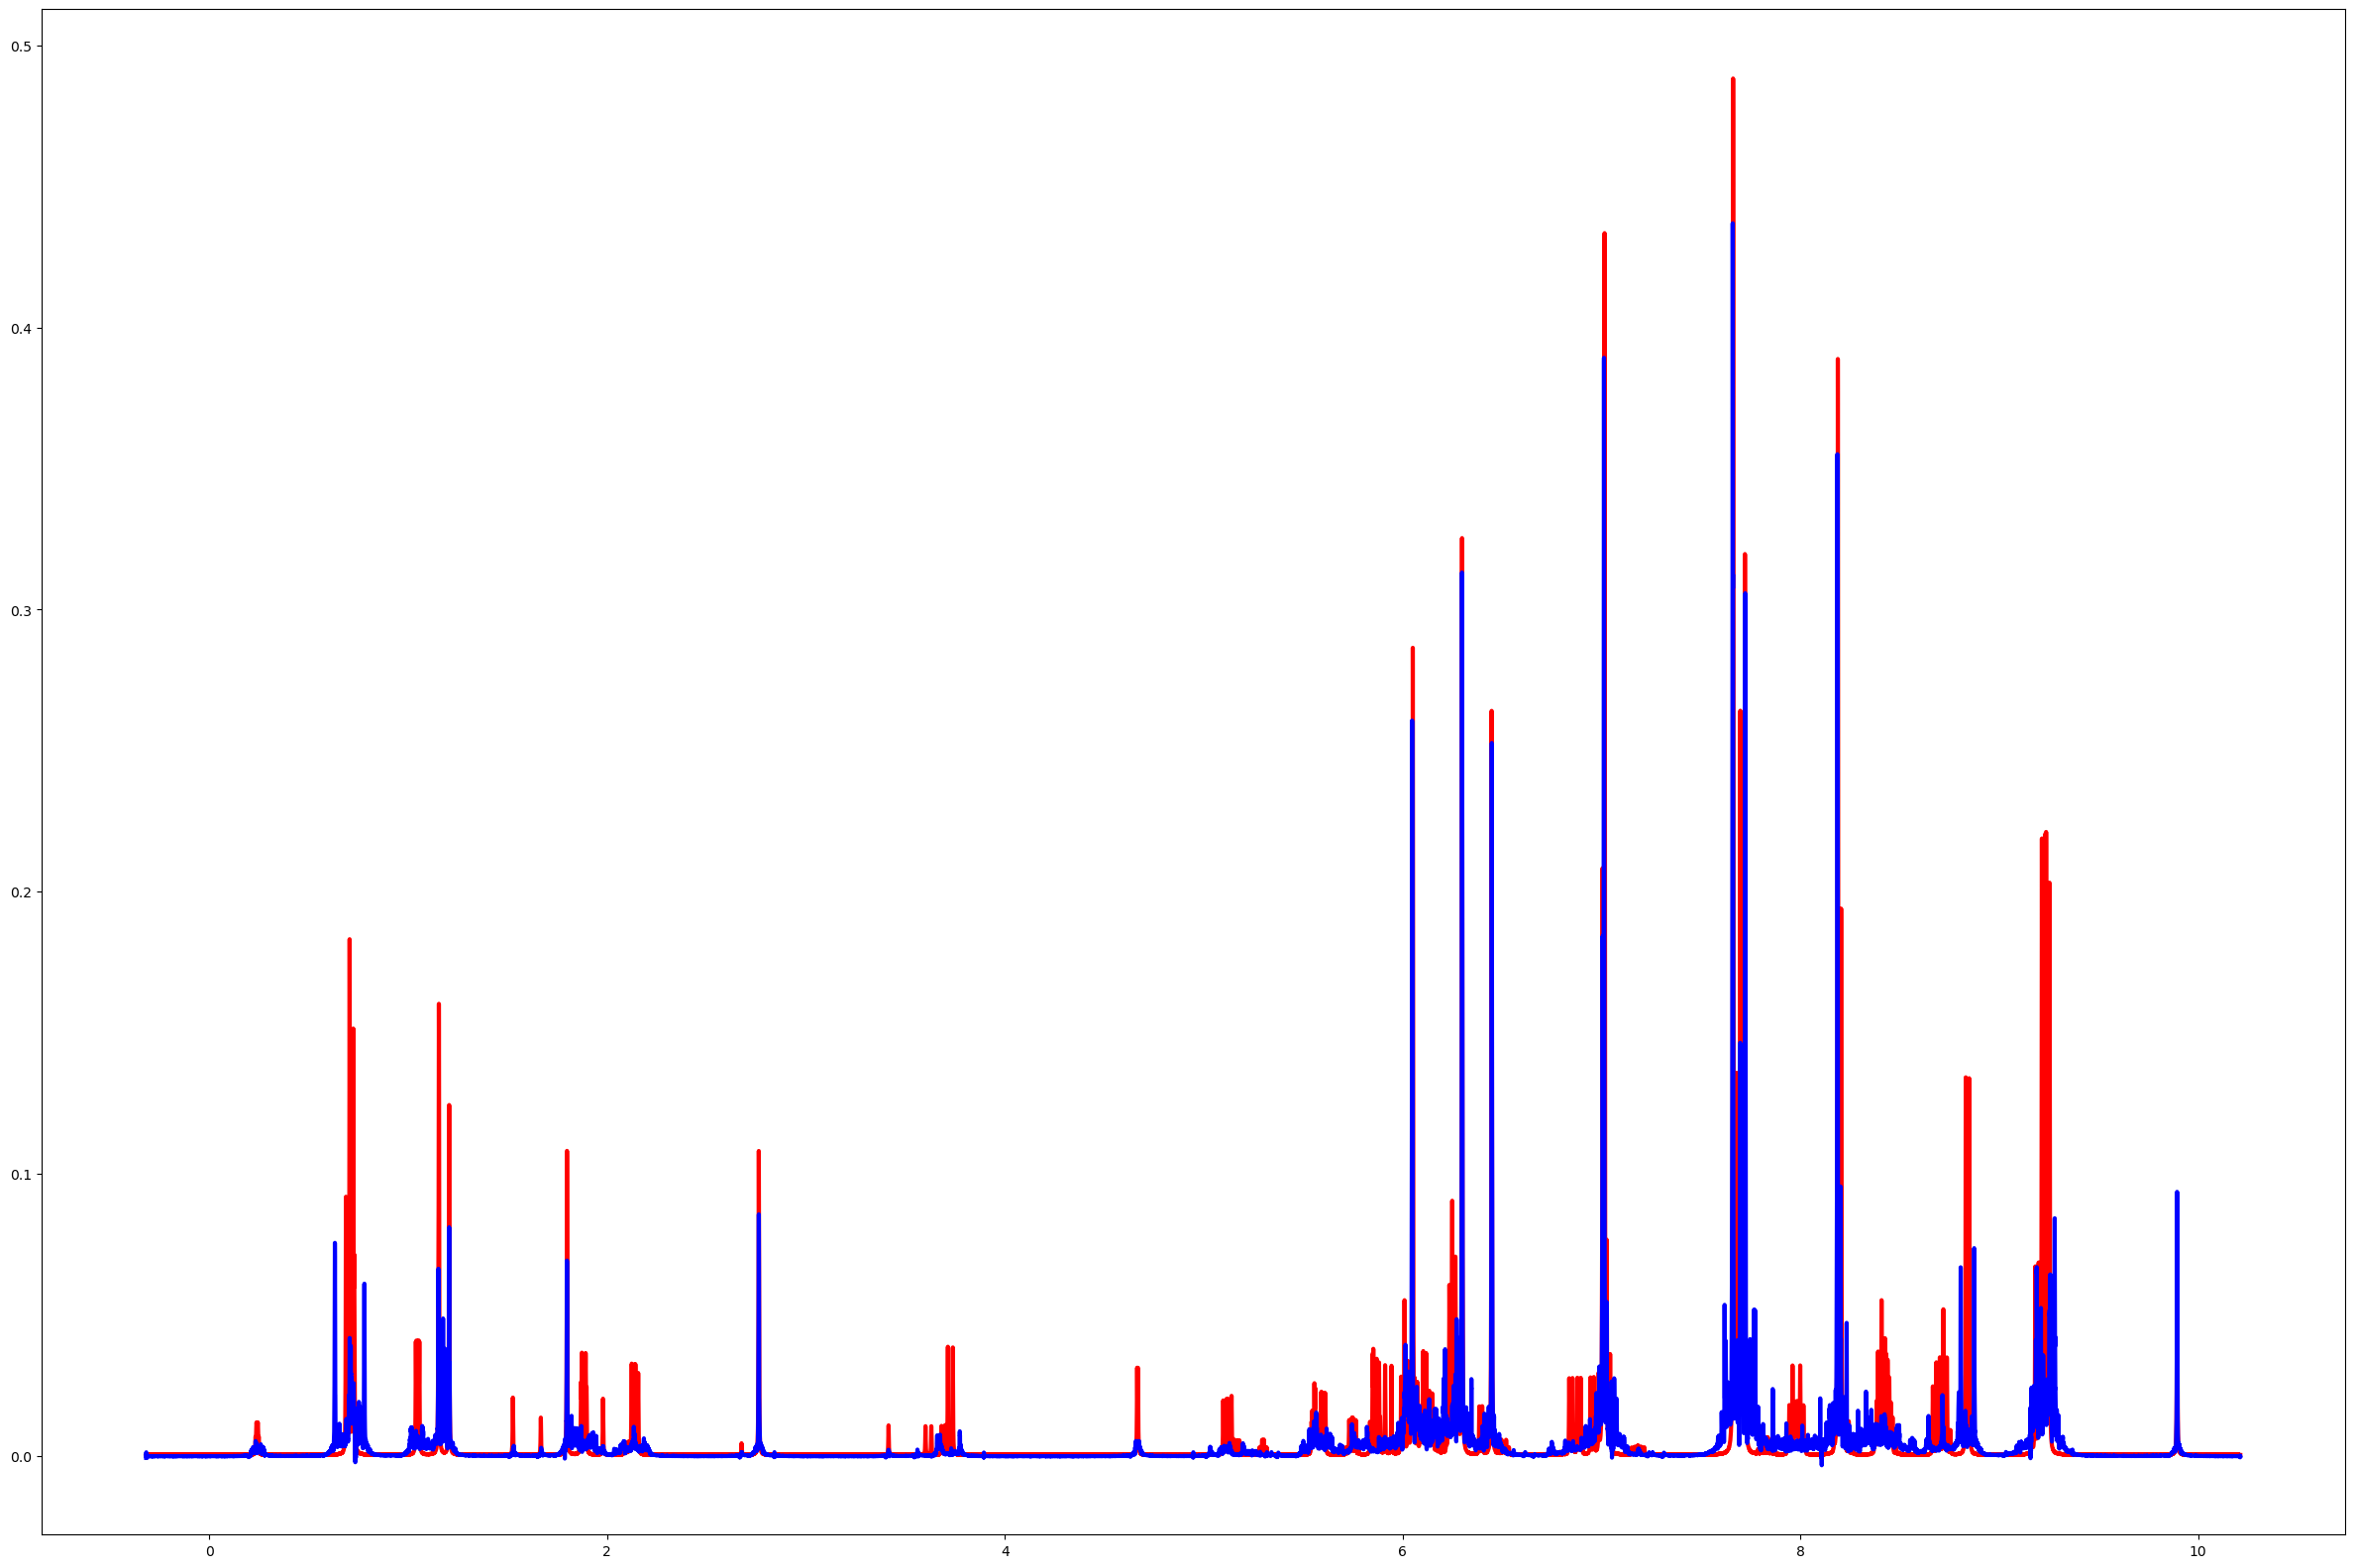

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


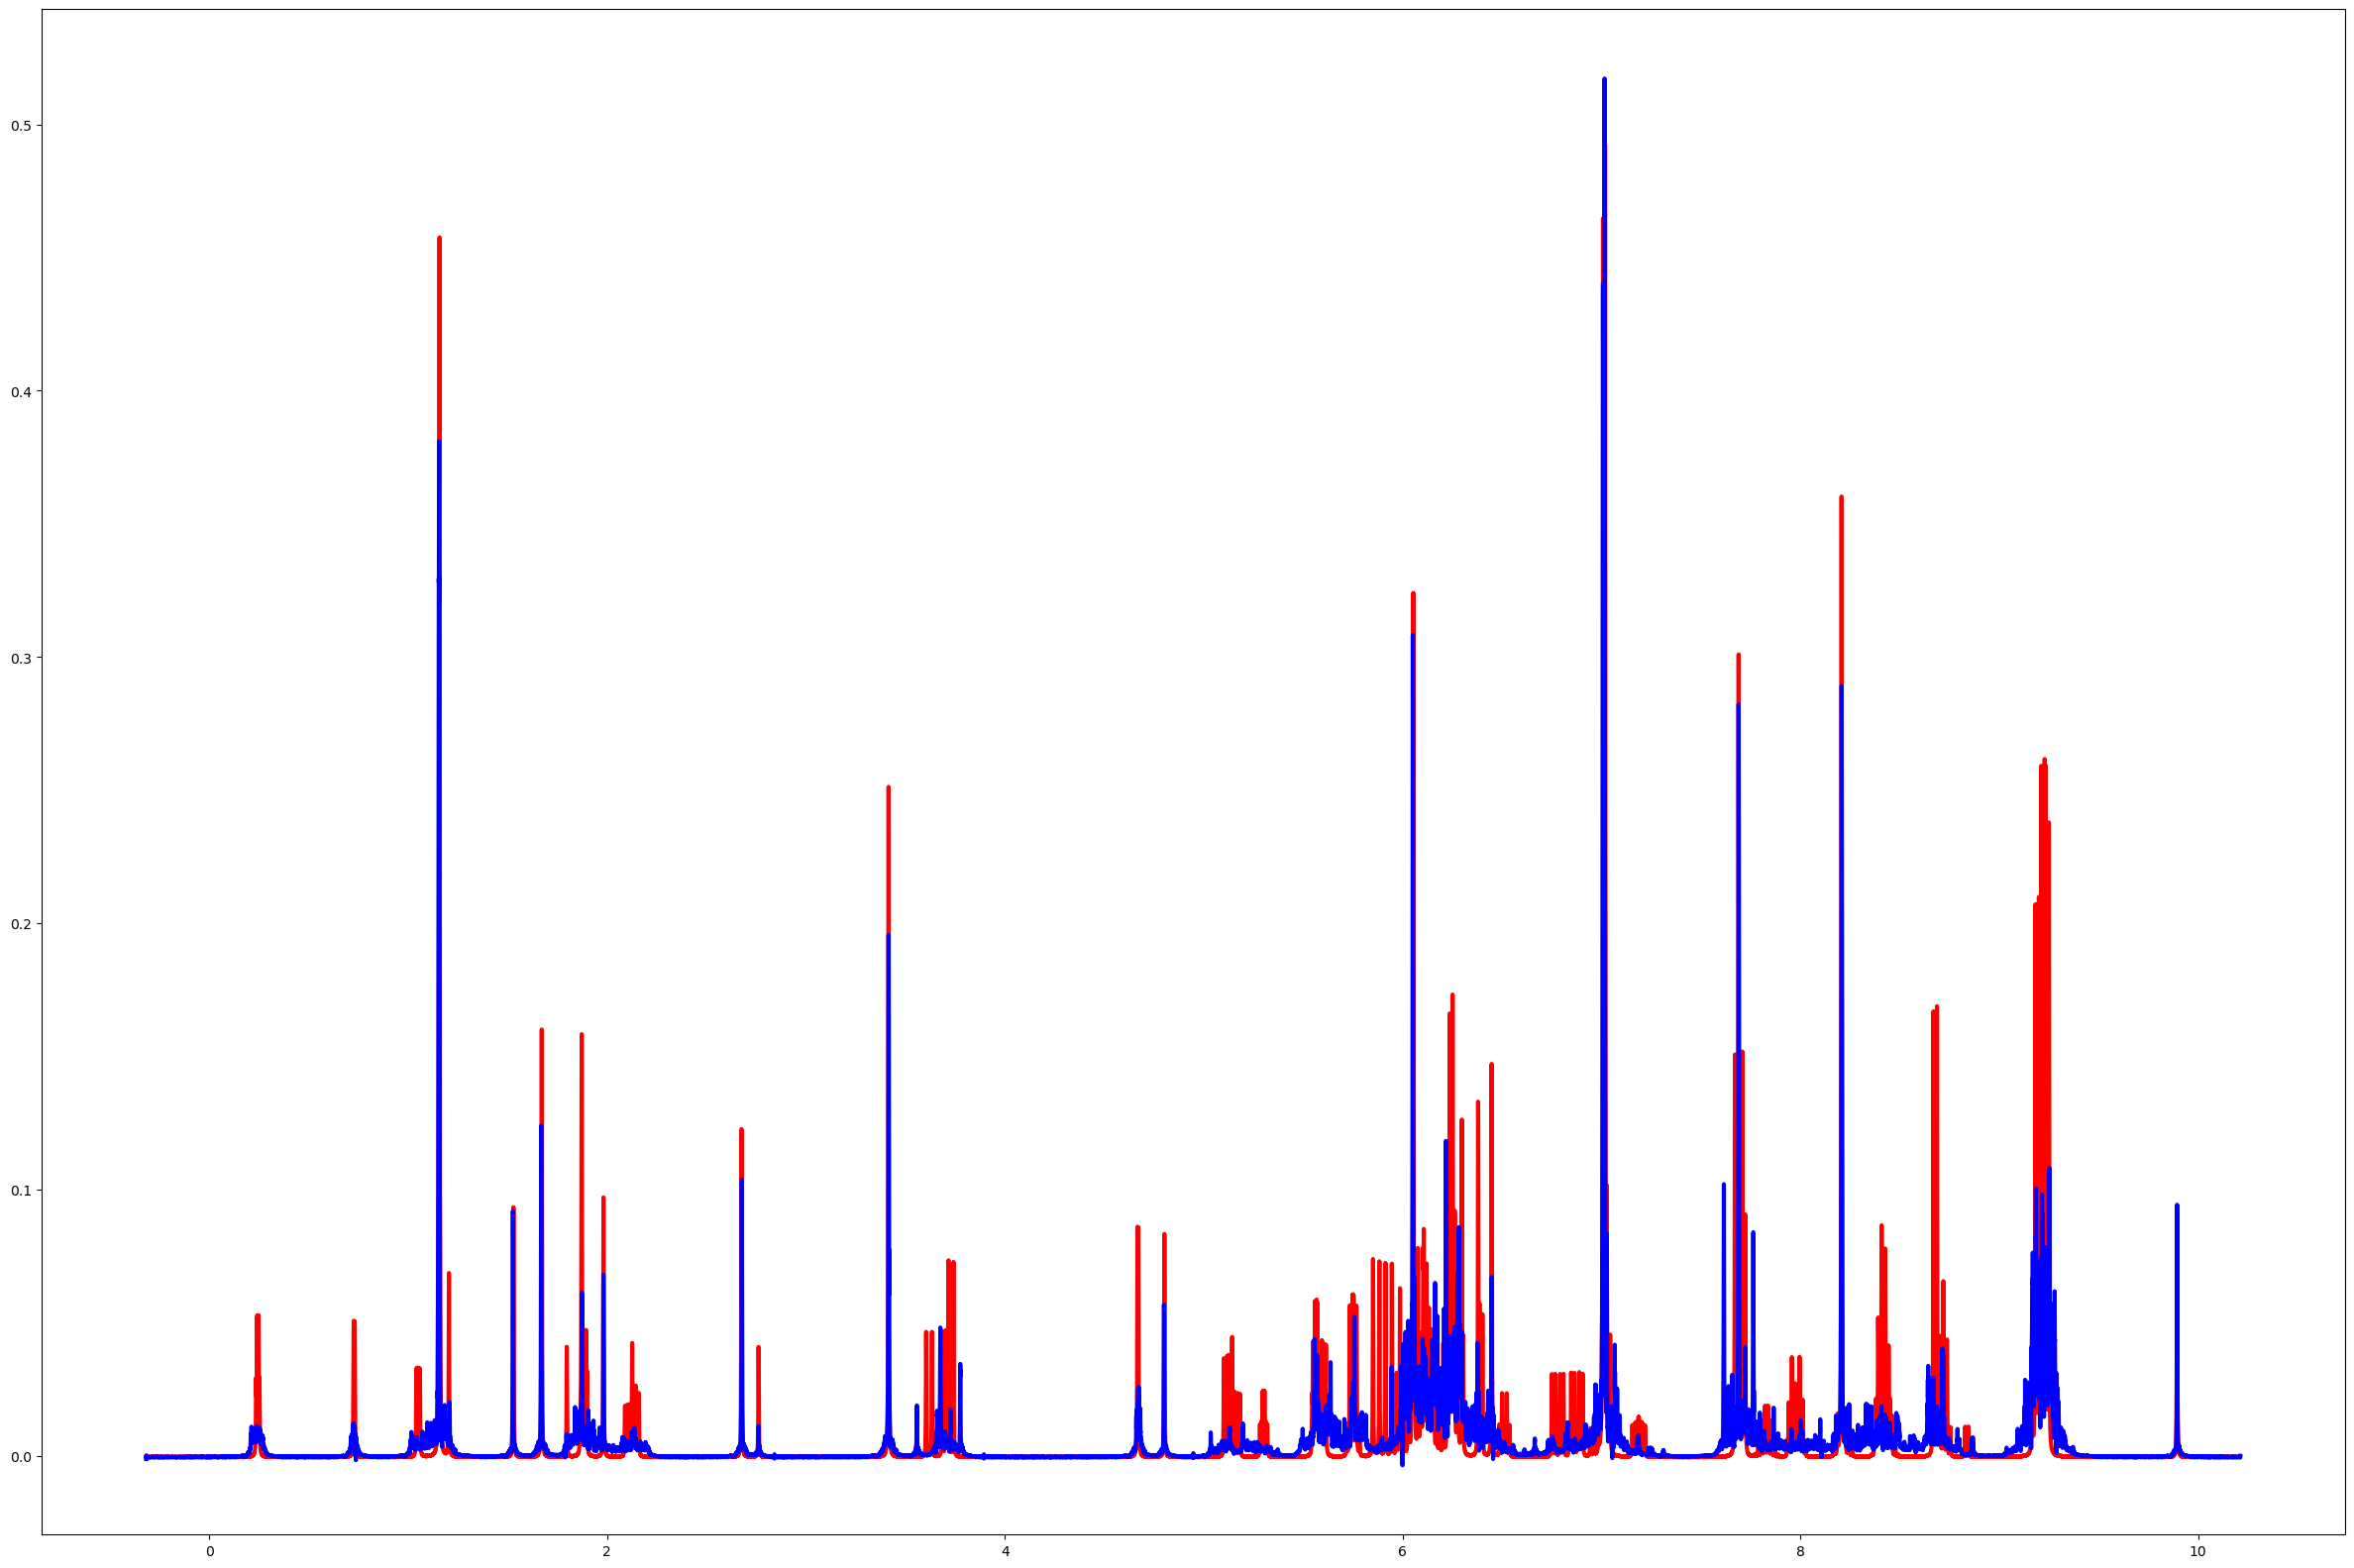

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


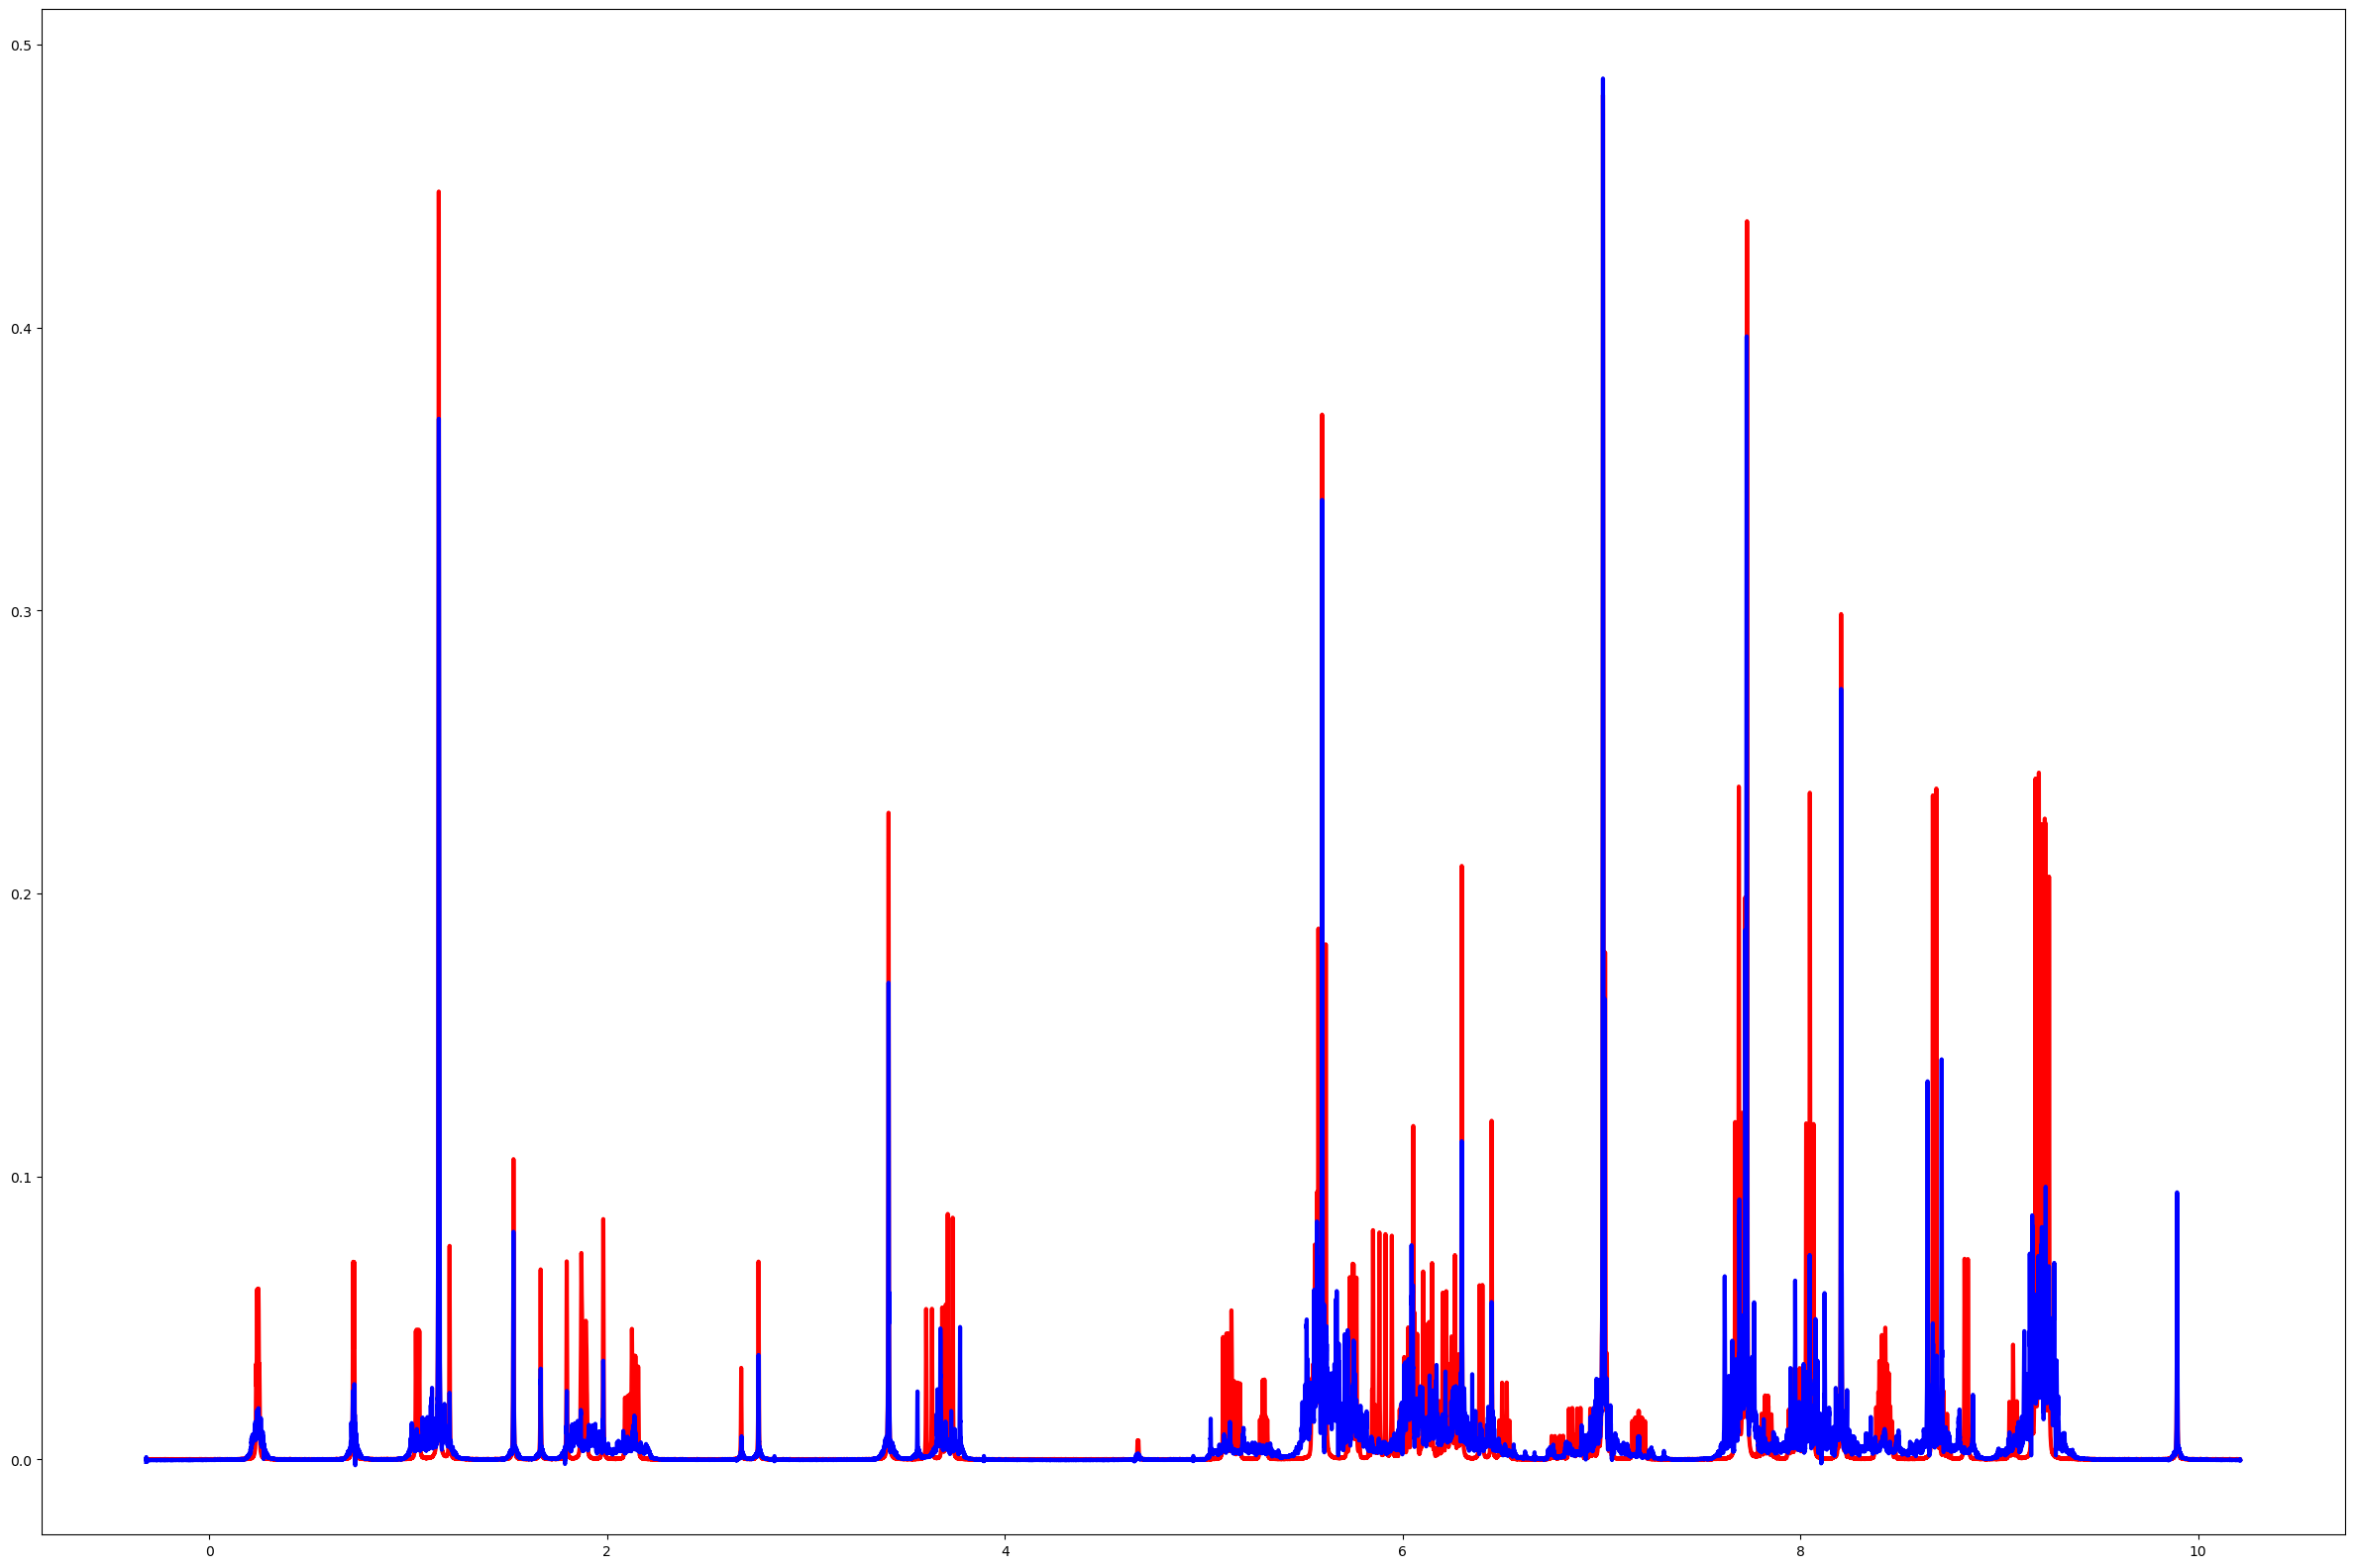

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


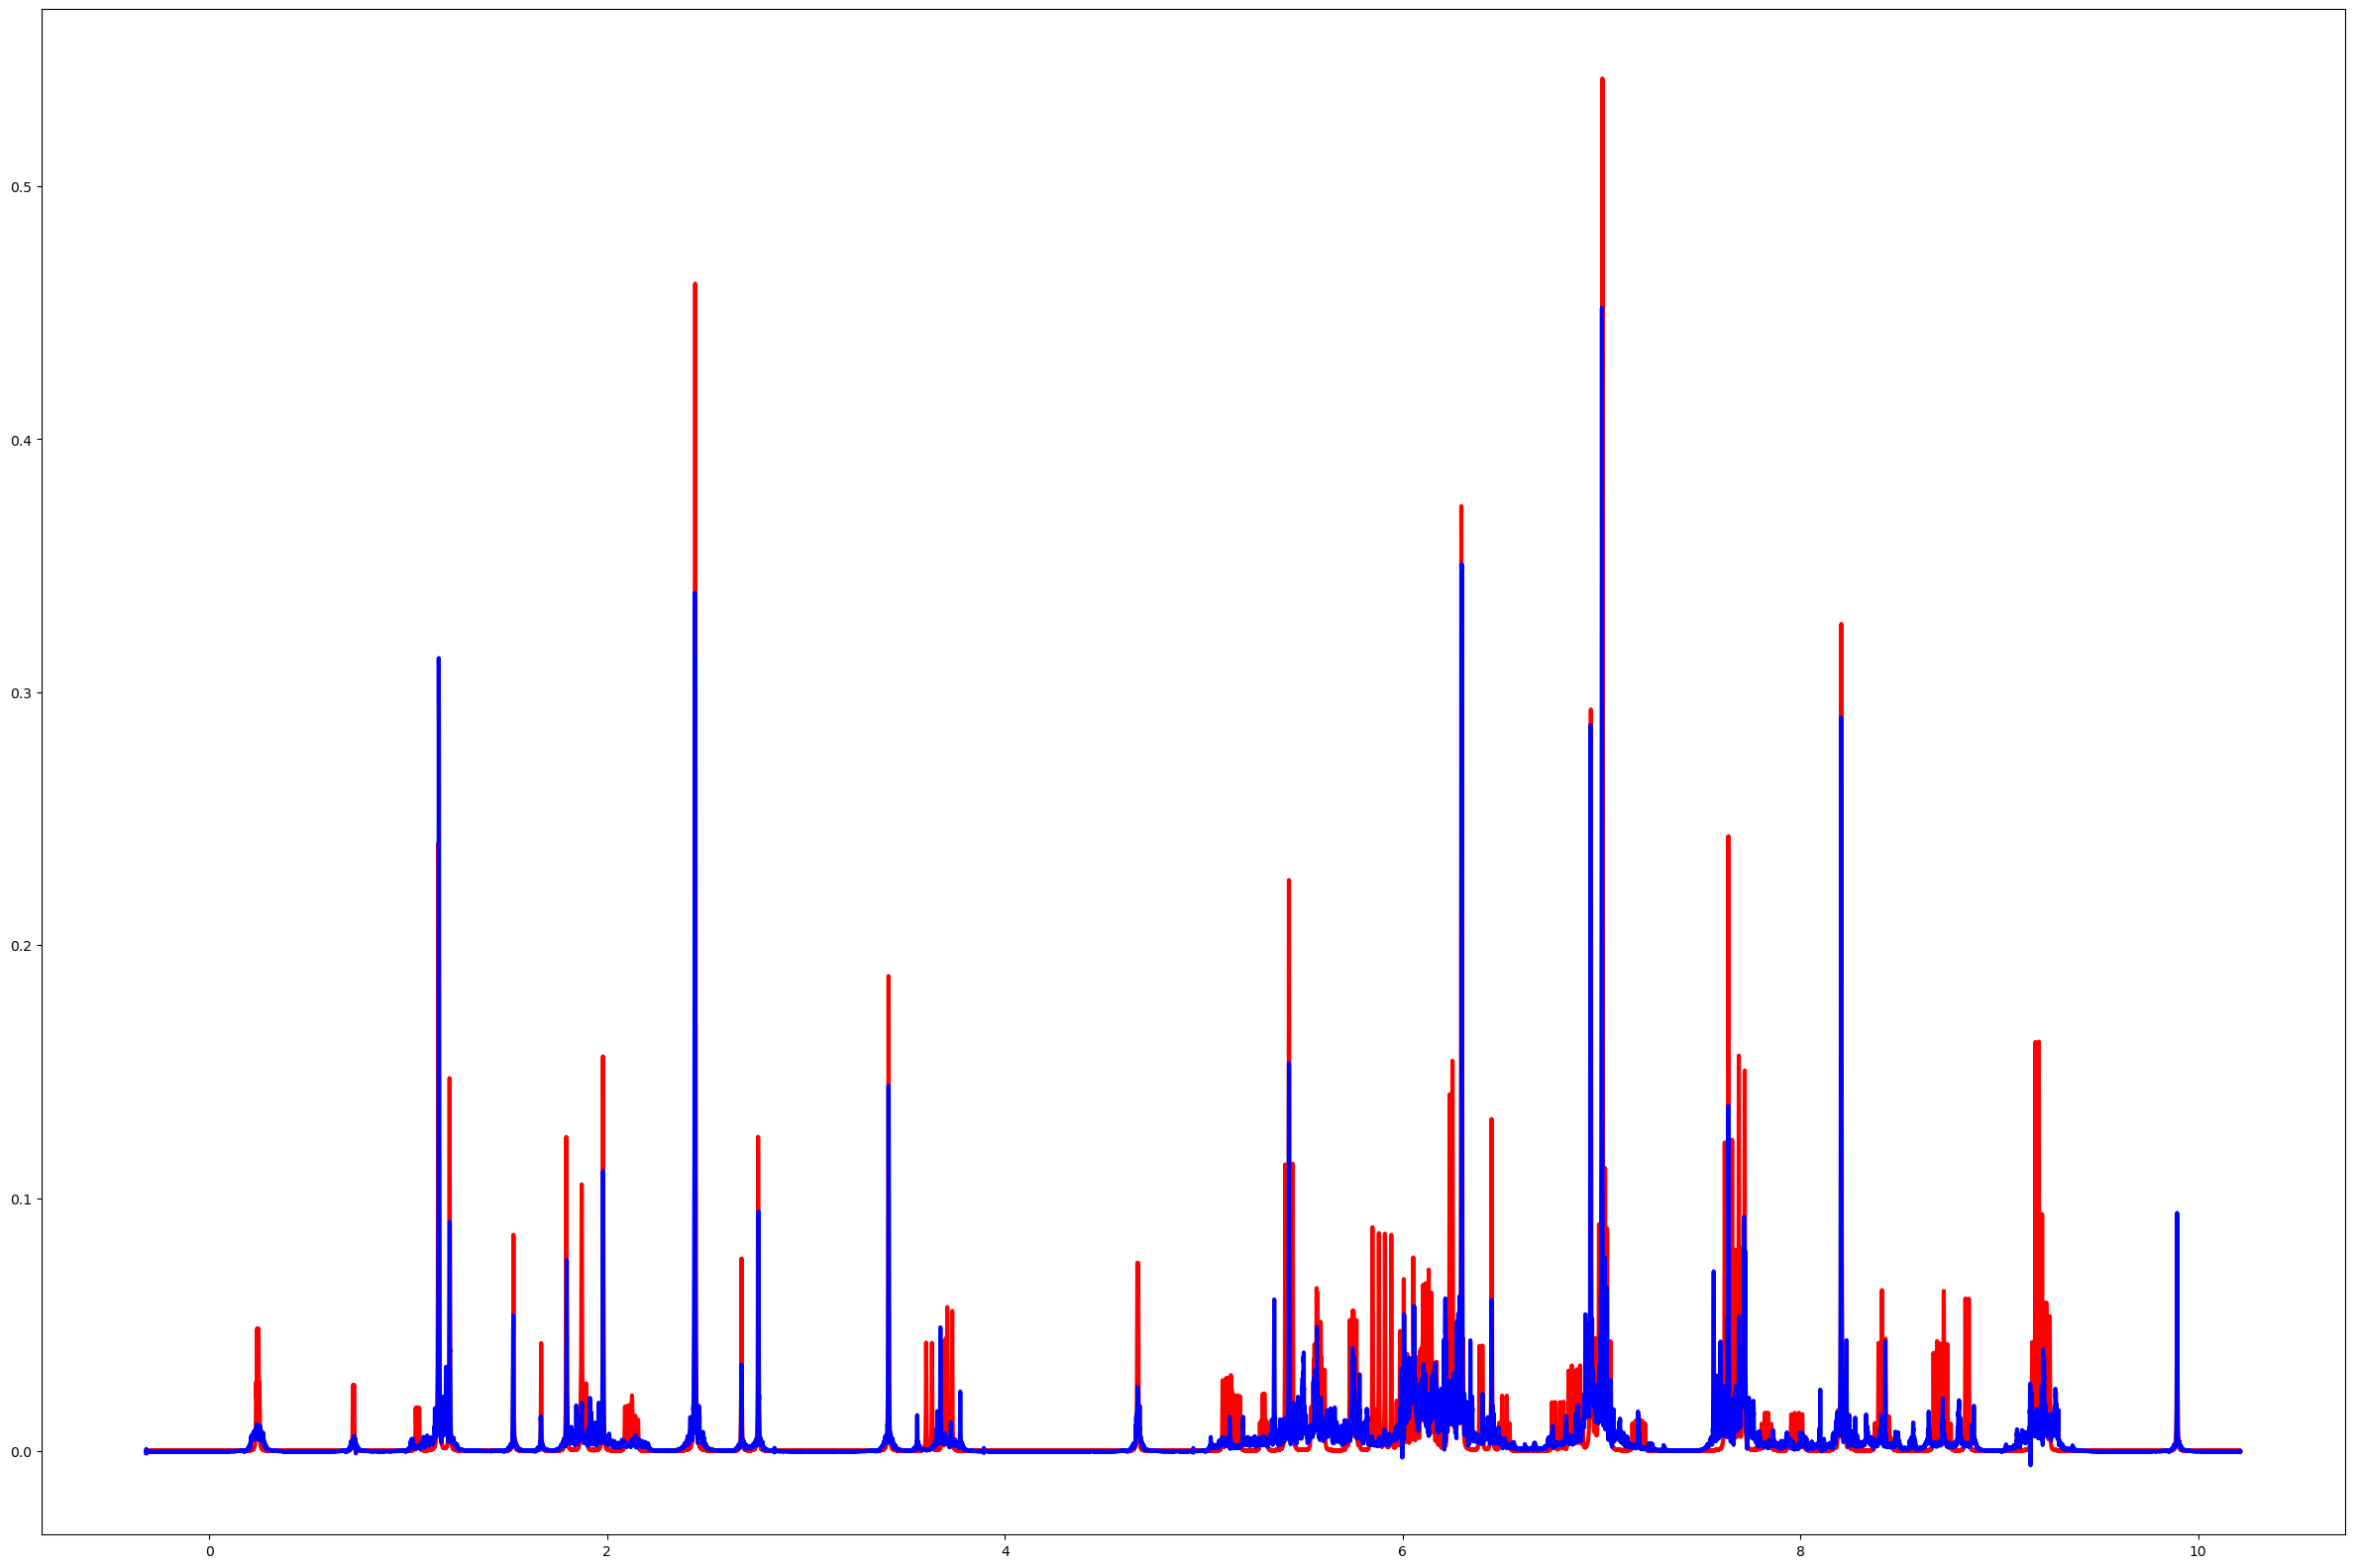

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


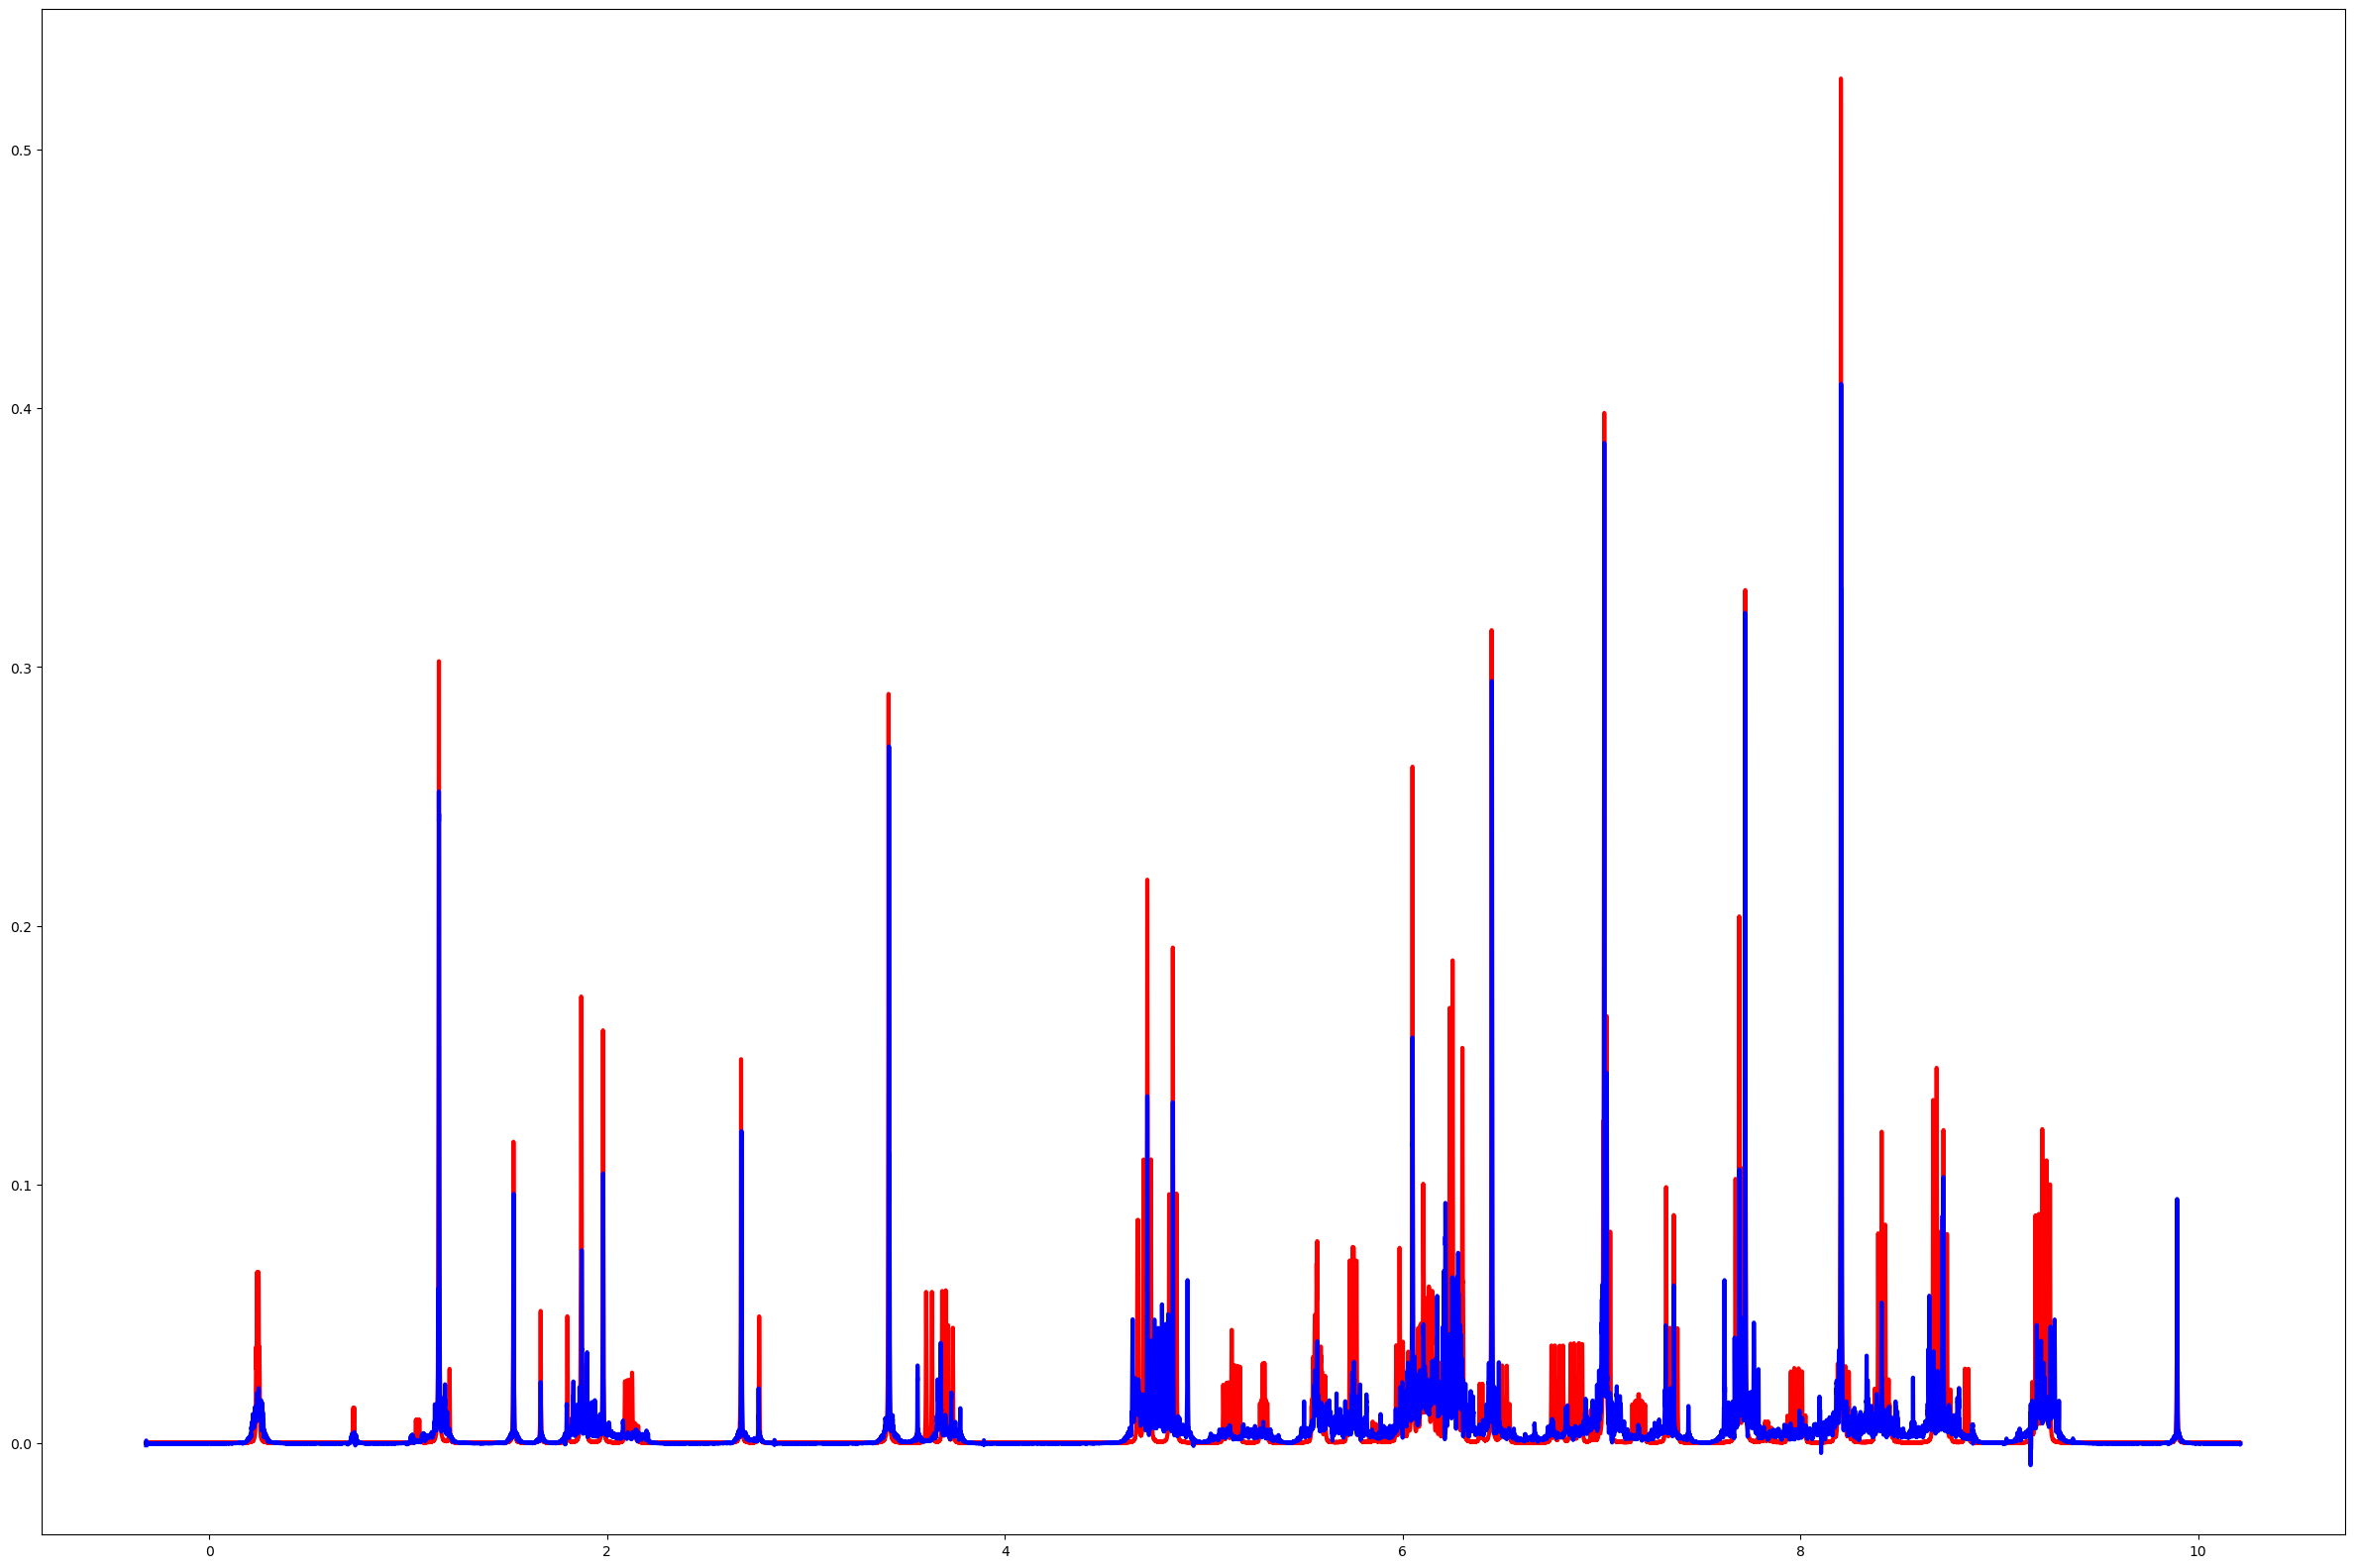

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


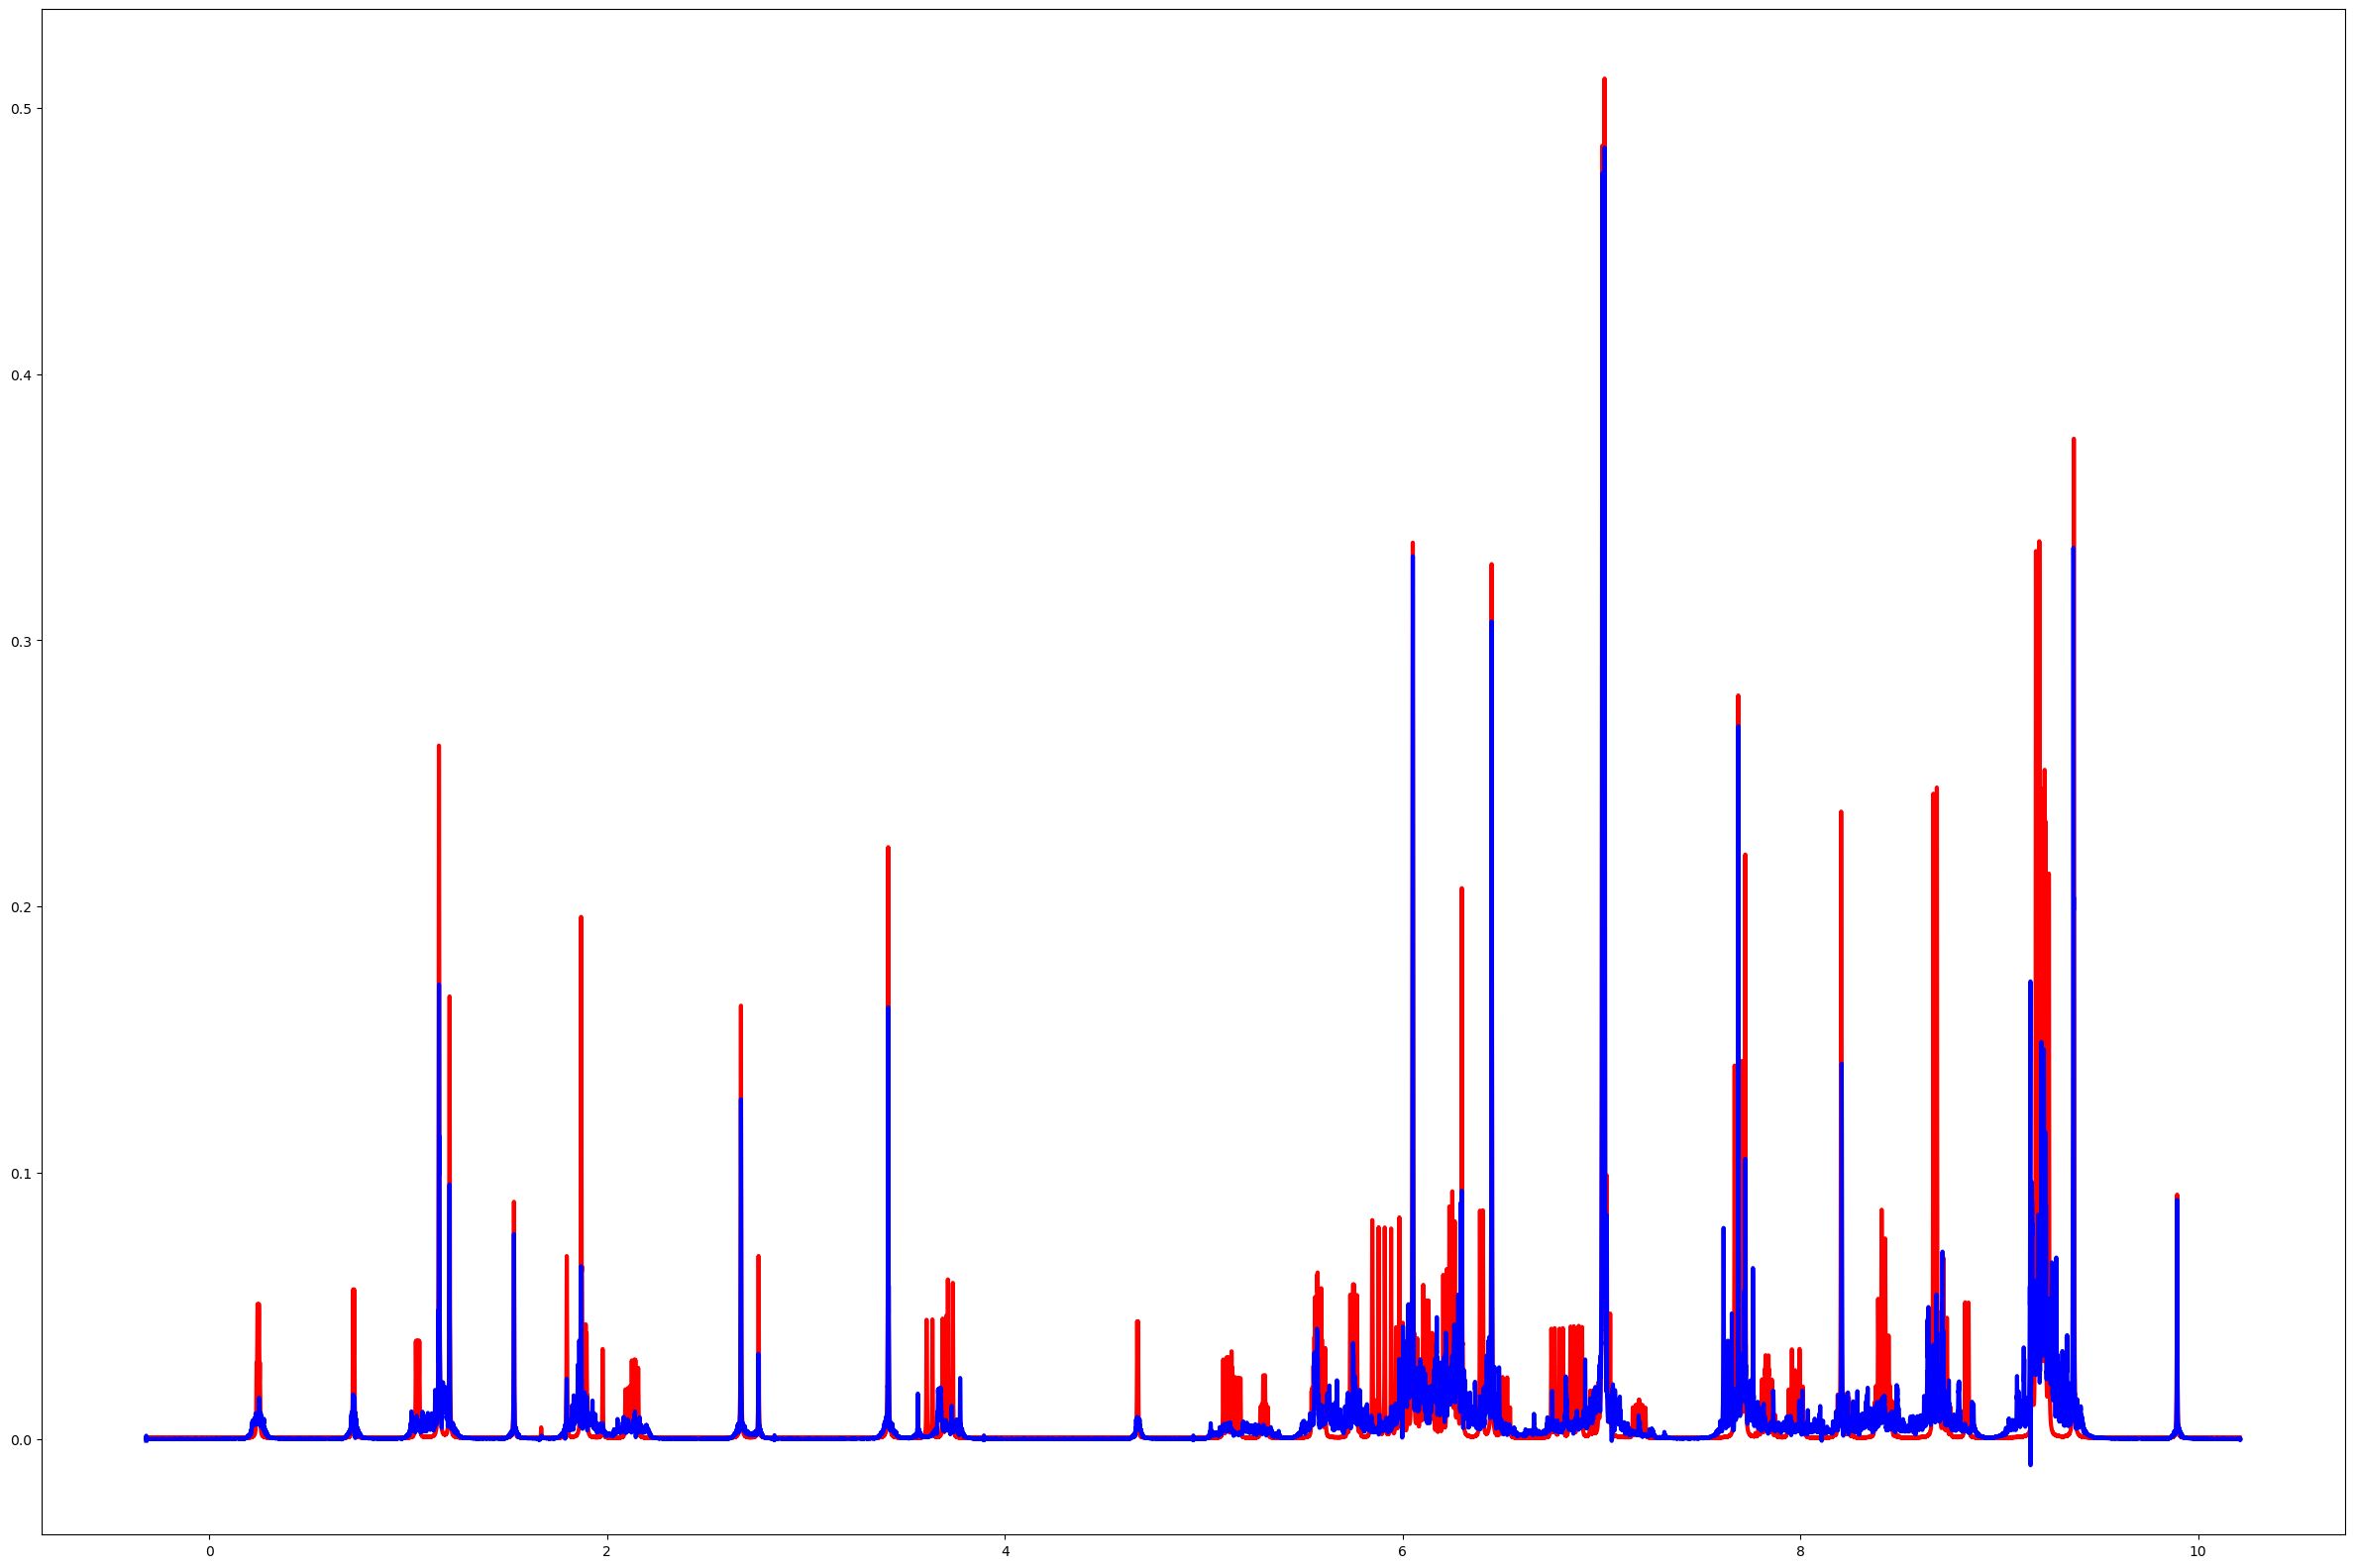

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


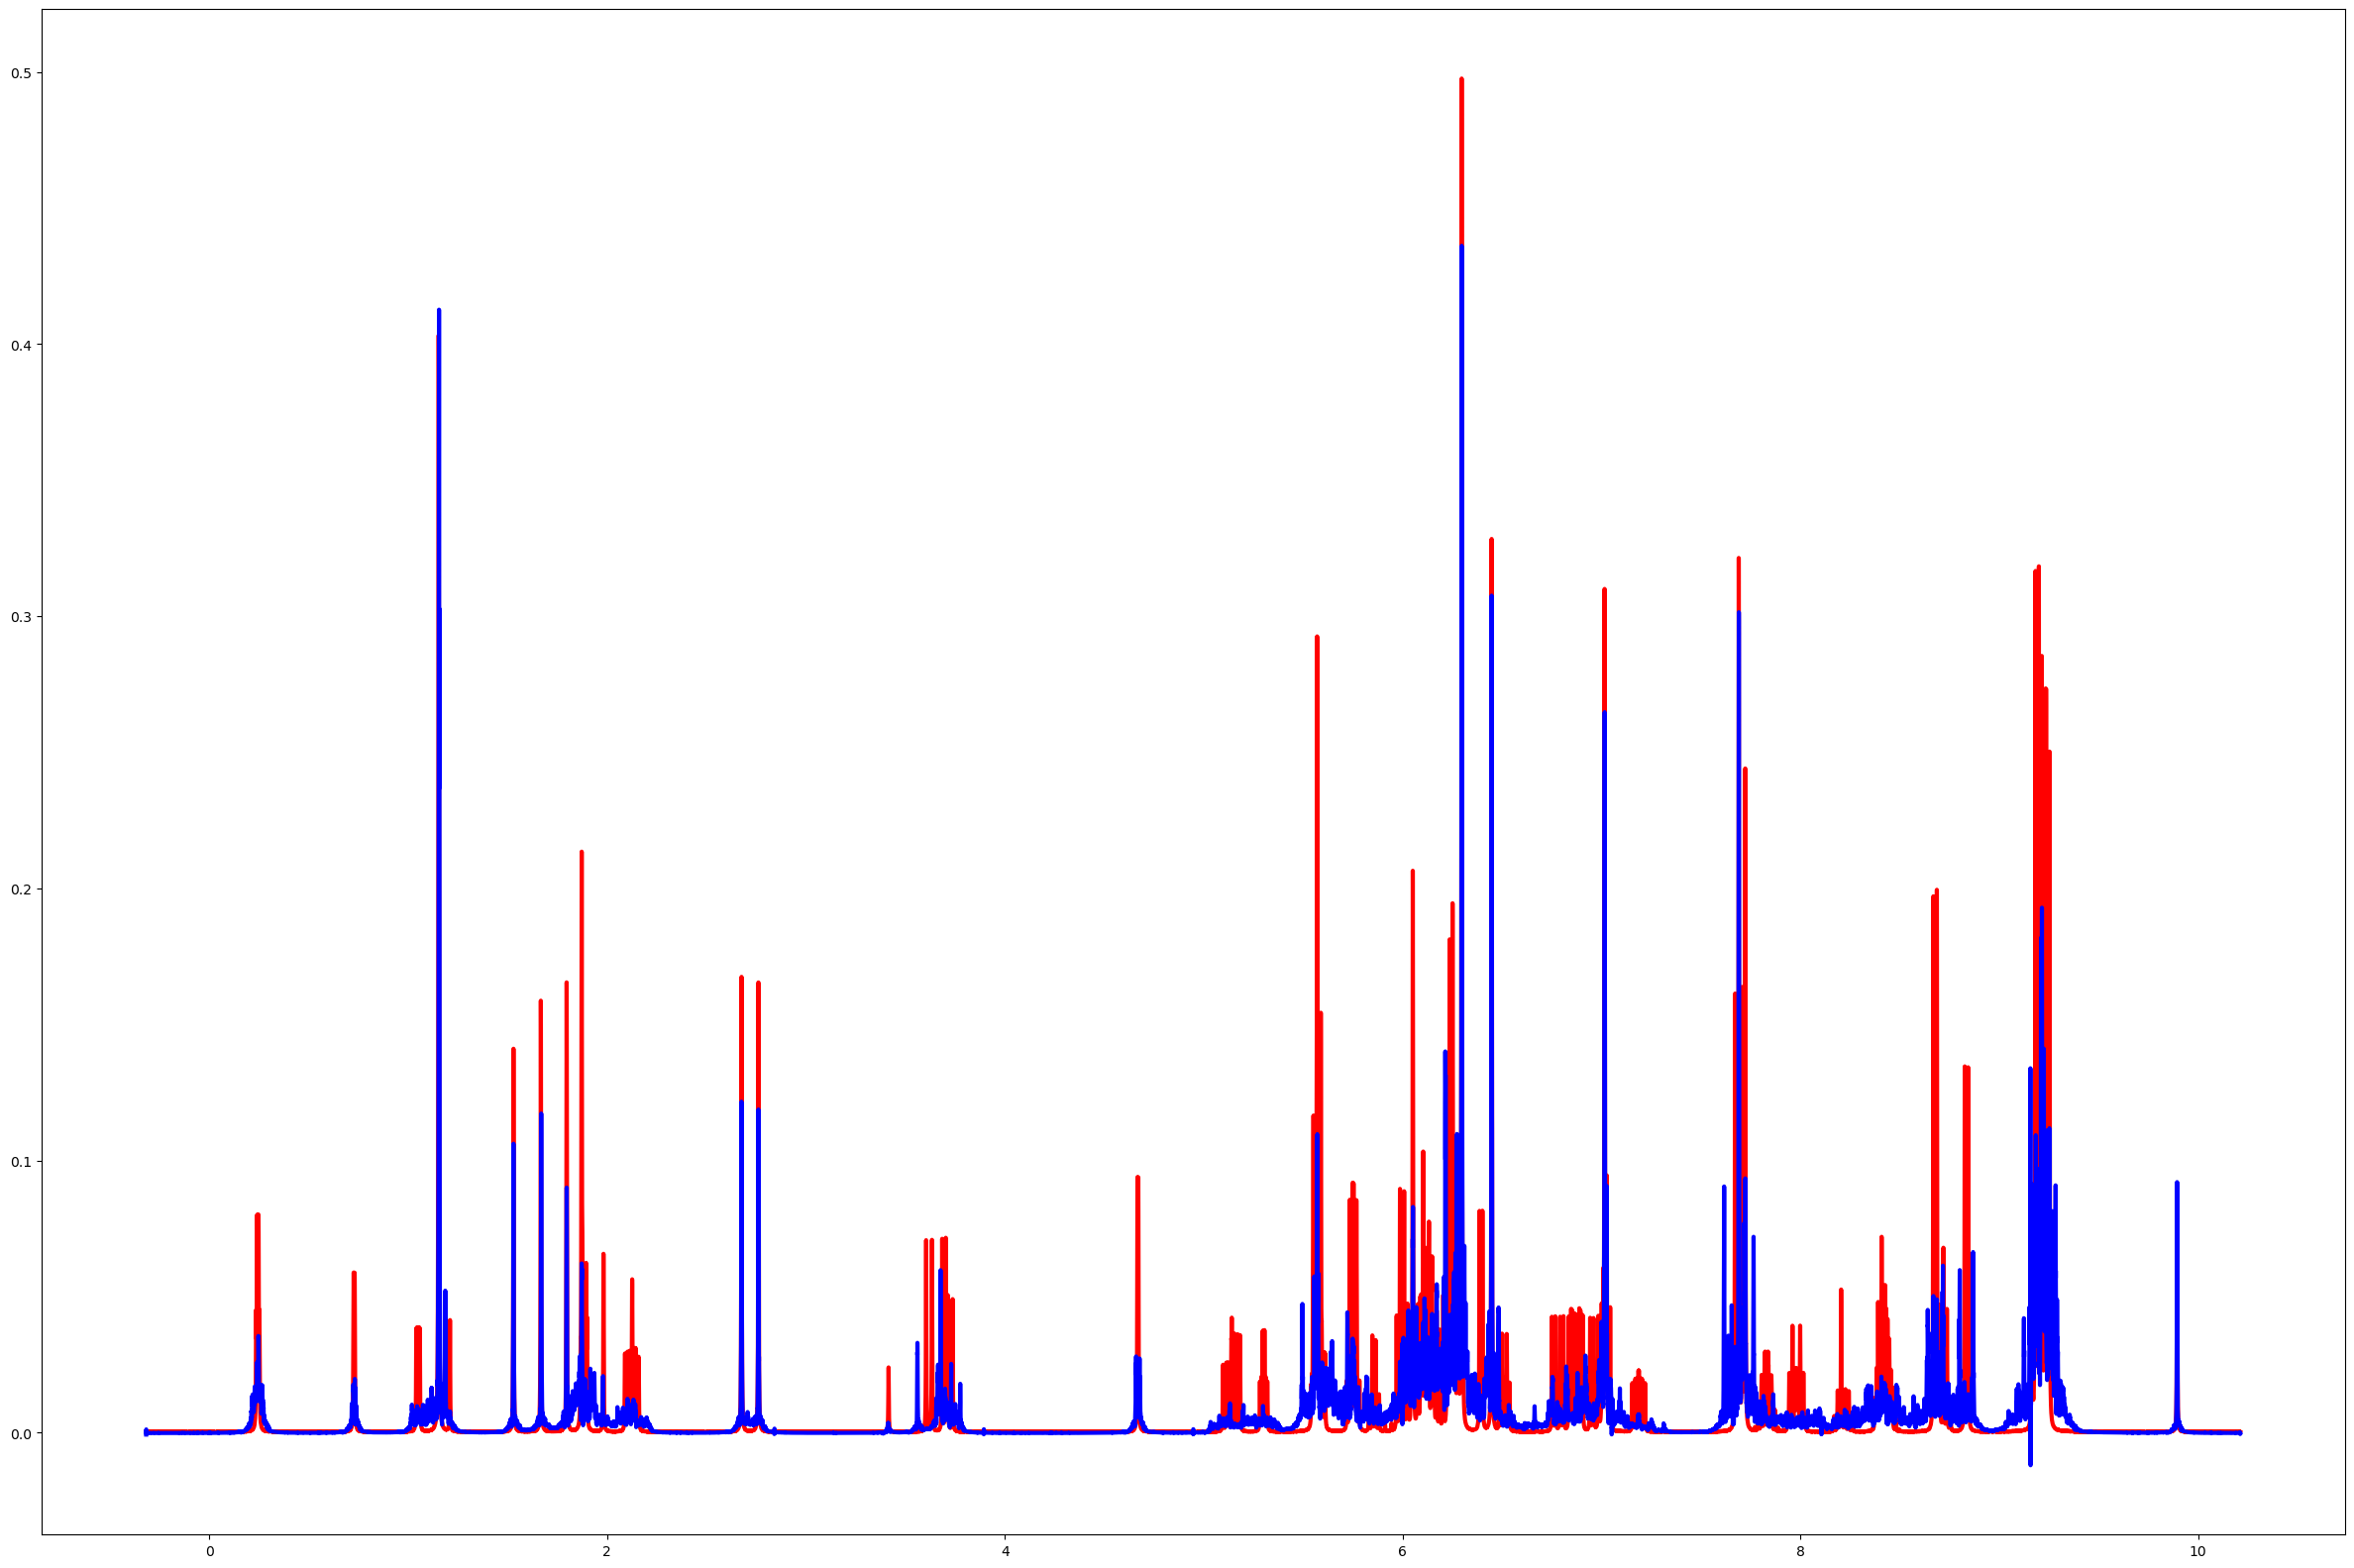

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


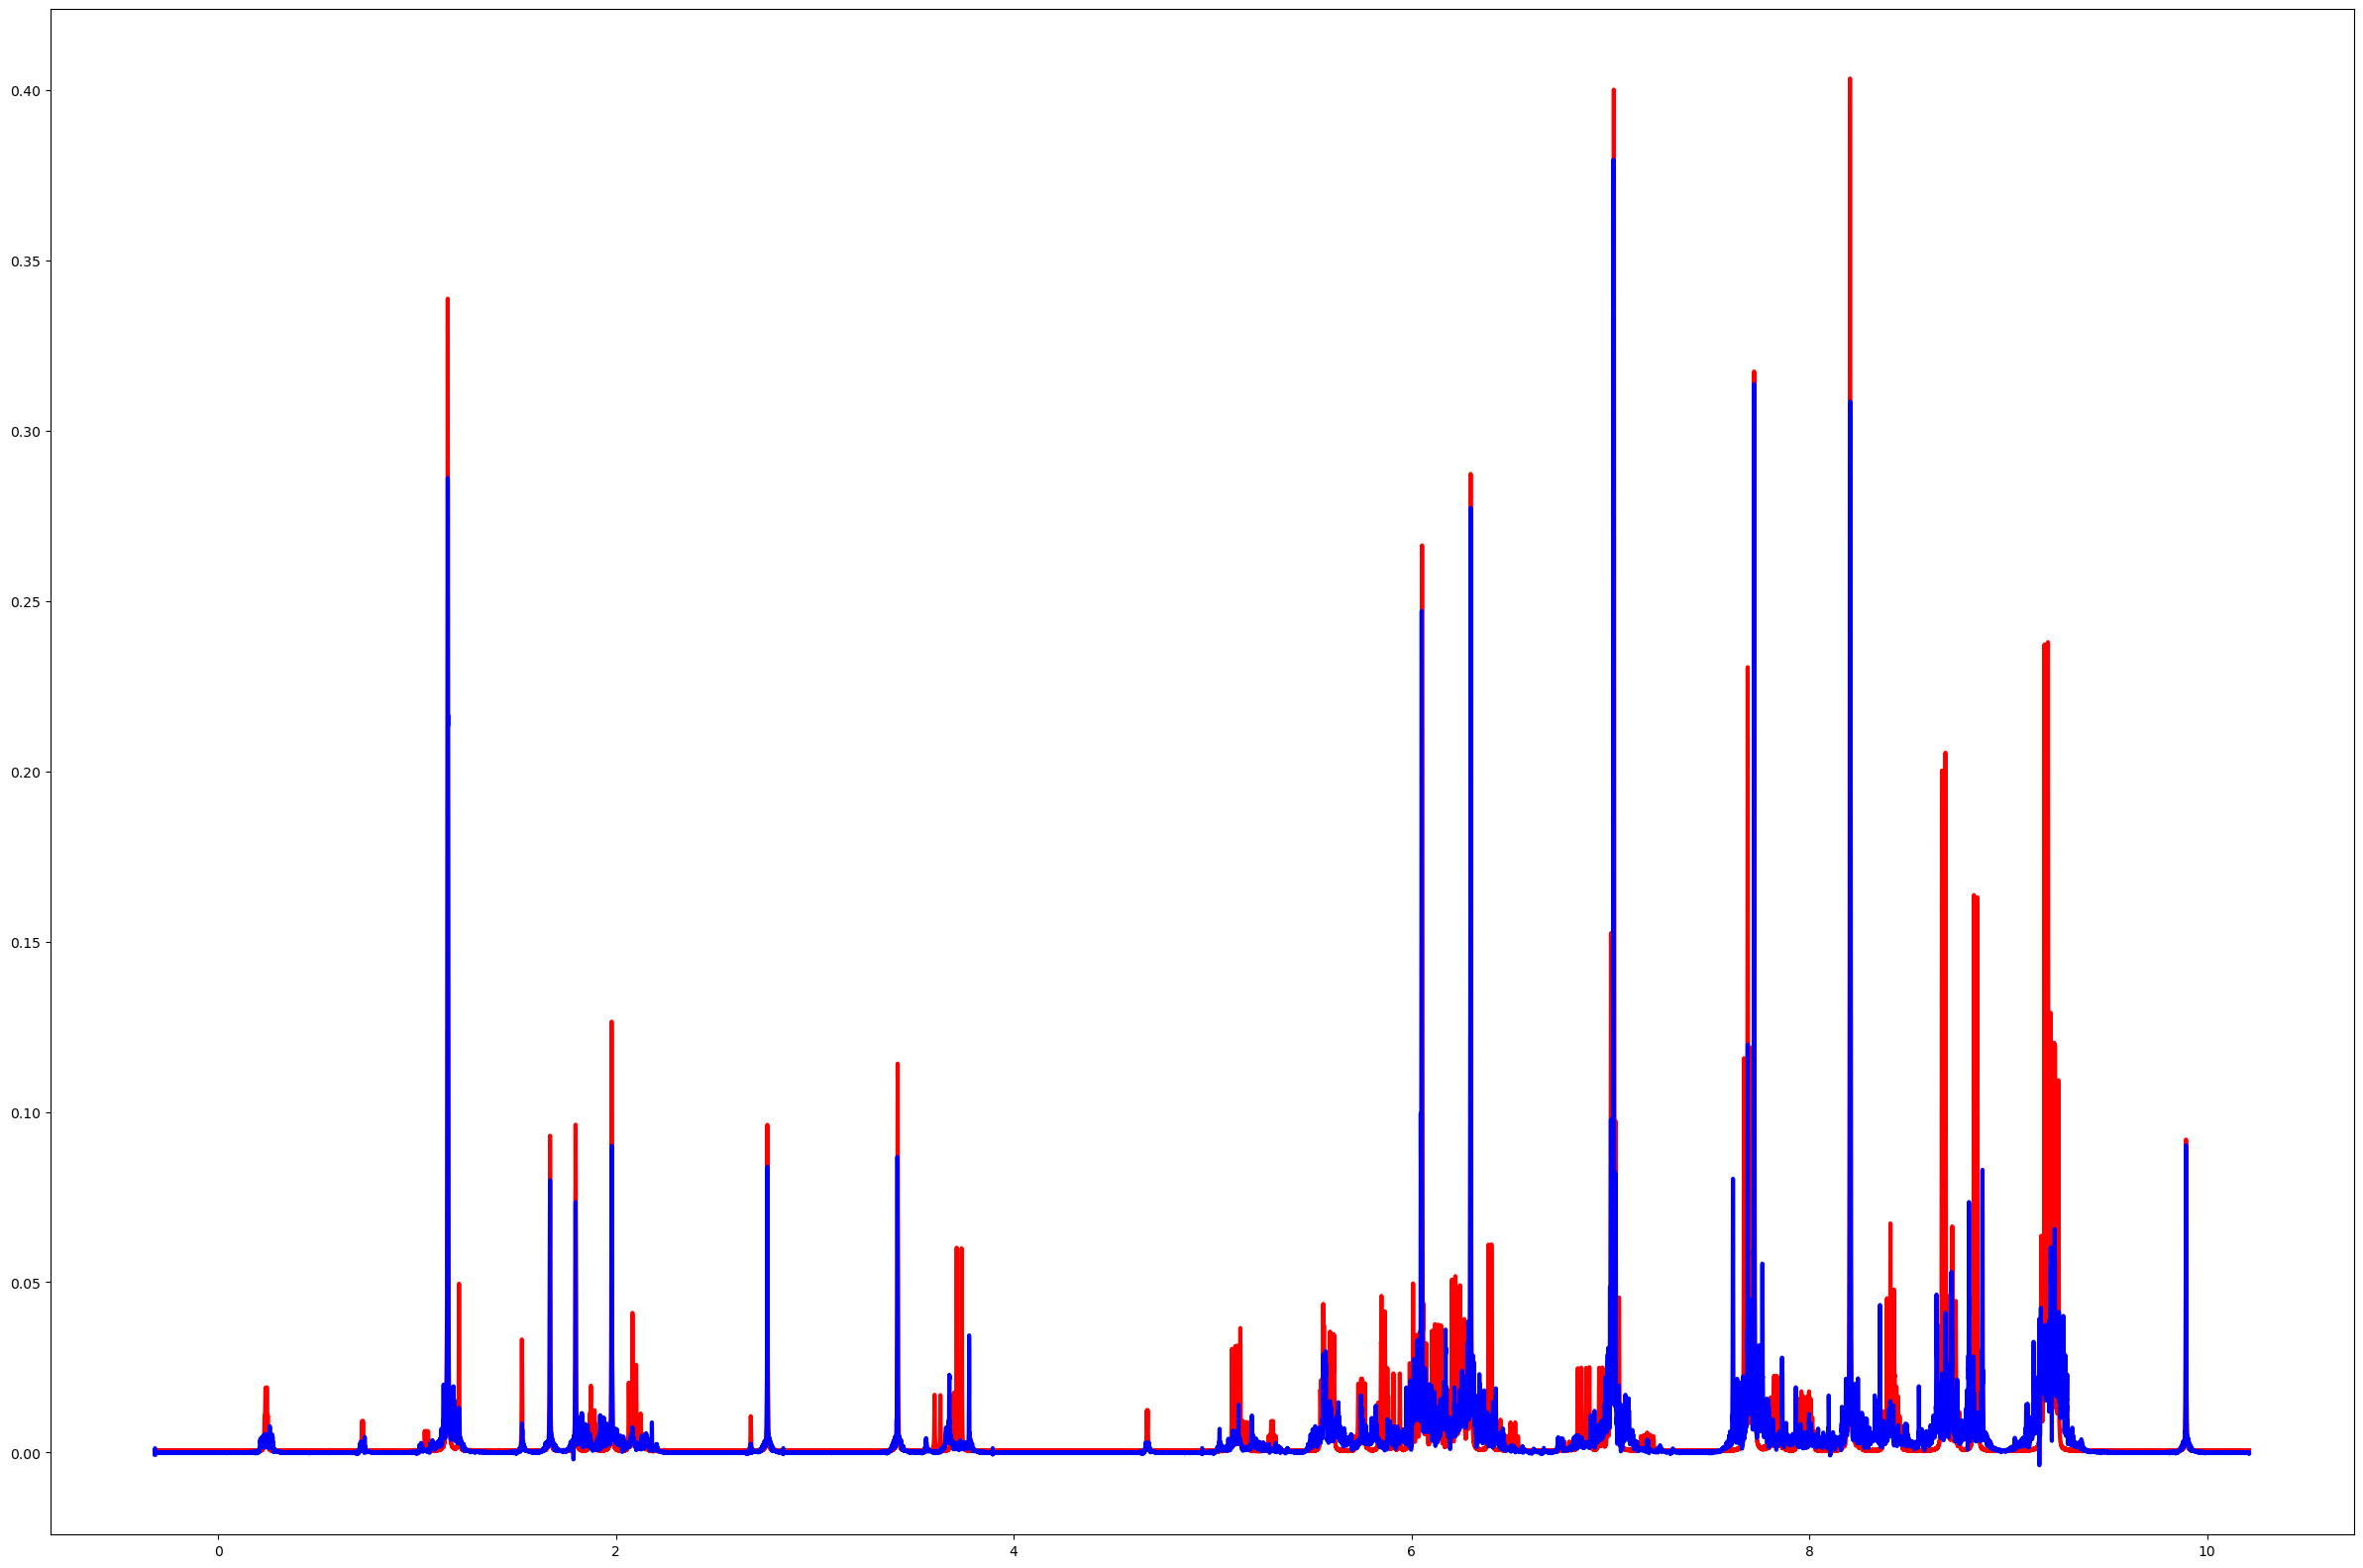

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


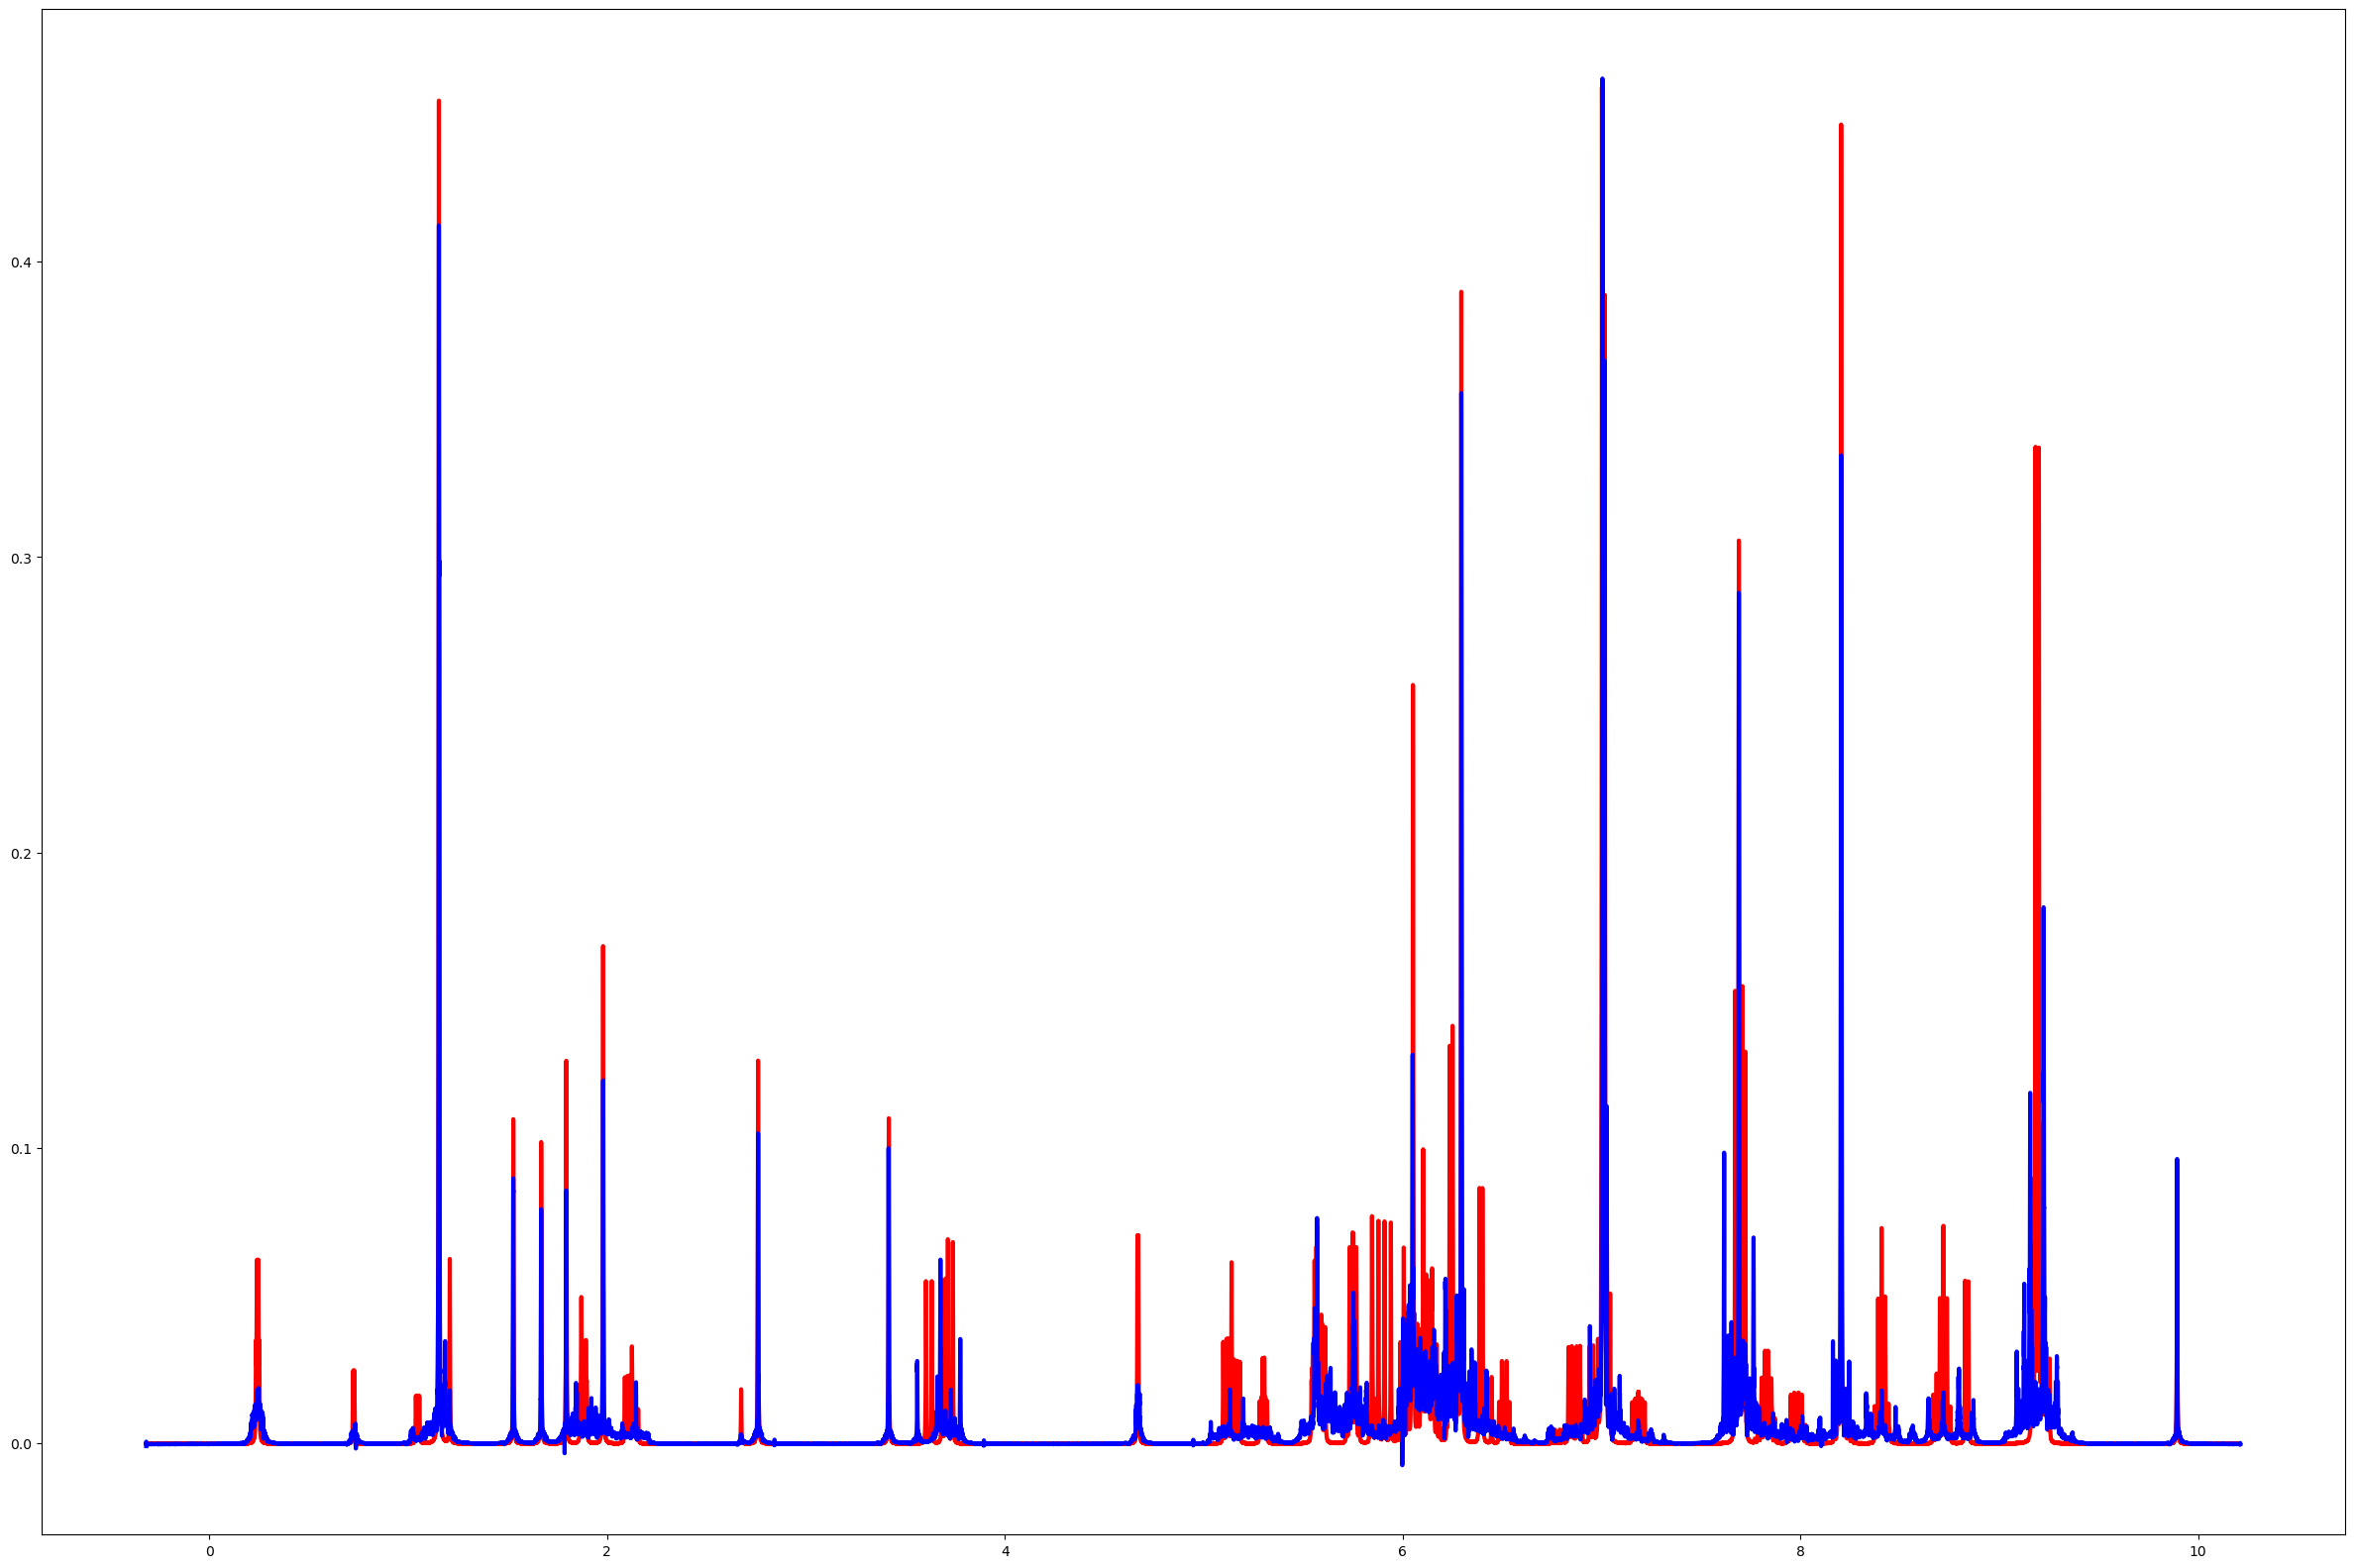

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:

LF = spectraVal100[:100]
GT = spectraVal400[:100]
criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF.unsqueeze(1)).cpu().detach().numpy()

for i in np.arange(10):
    plt.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color = 'red', linewidth = 3)
    plt.plot(np.flip(ppm), outputs[i][0], color = 'blue', linewidth = 3)
    plt.show()
    print(criterion(model(LF.unsqueeze(1))[i], GT[i]))

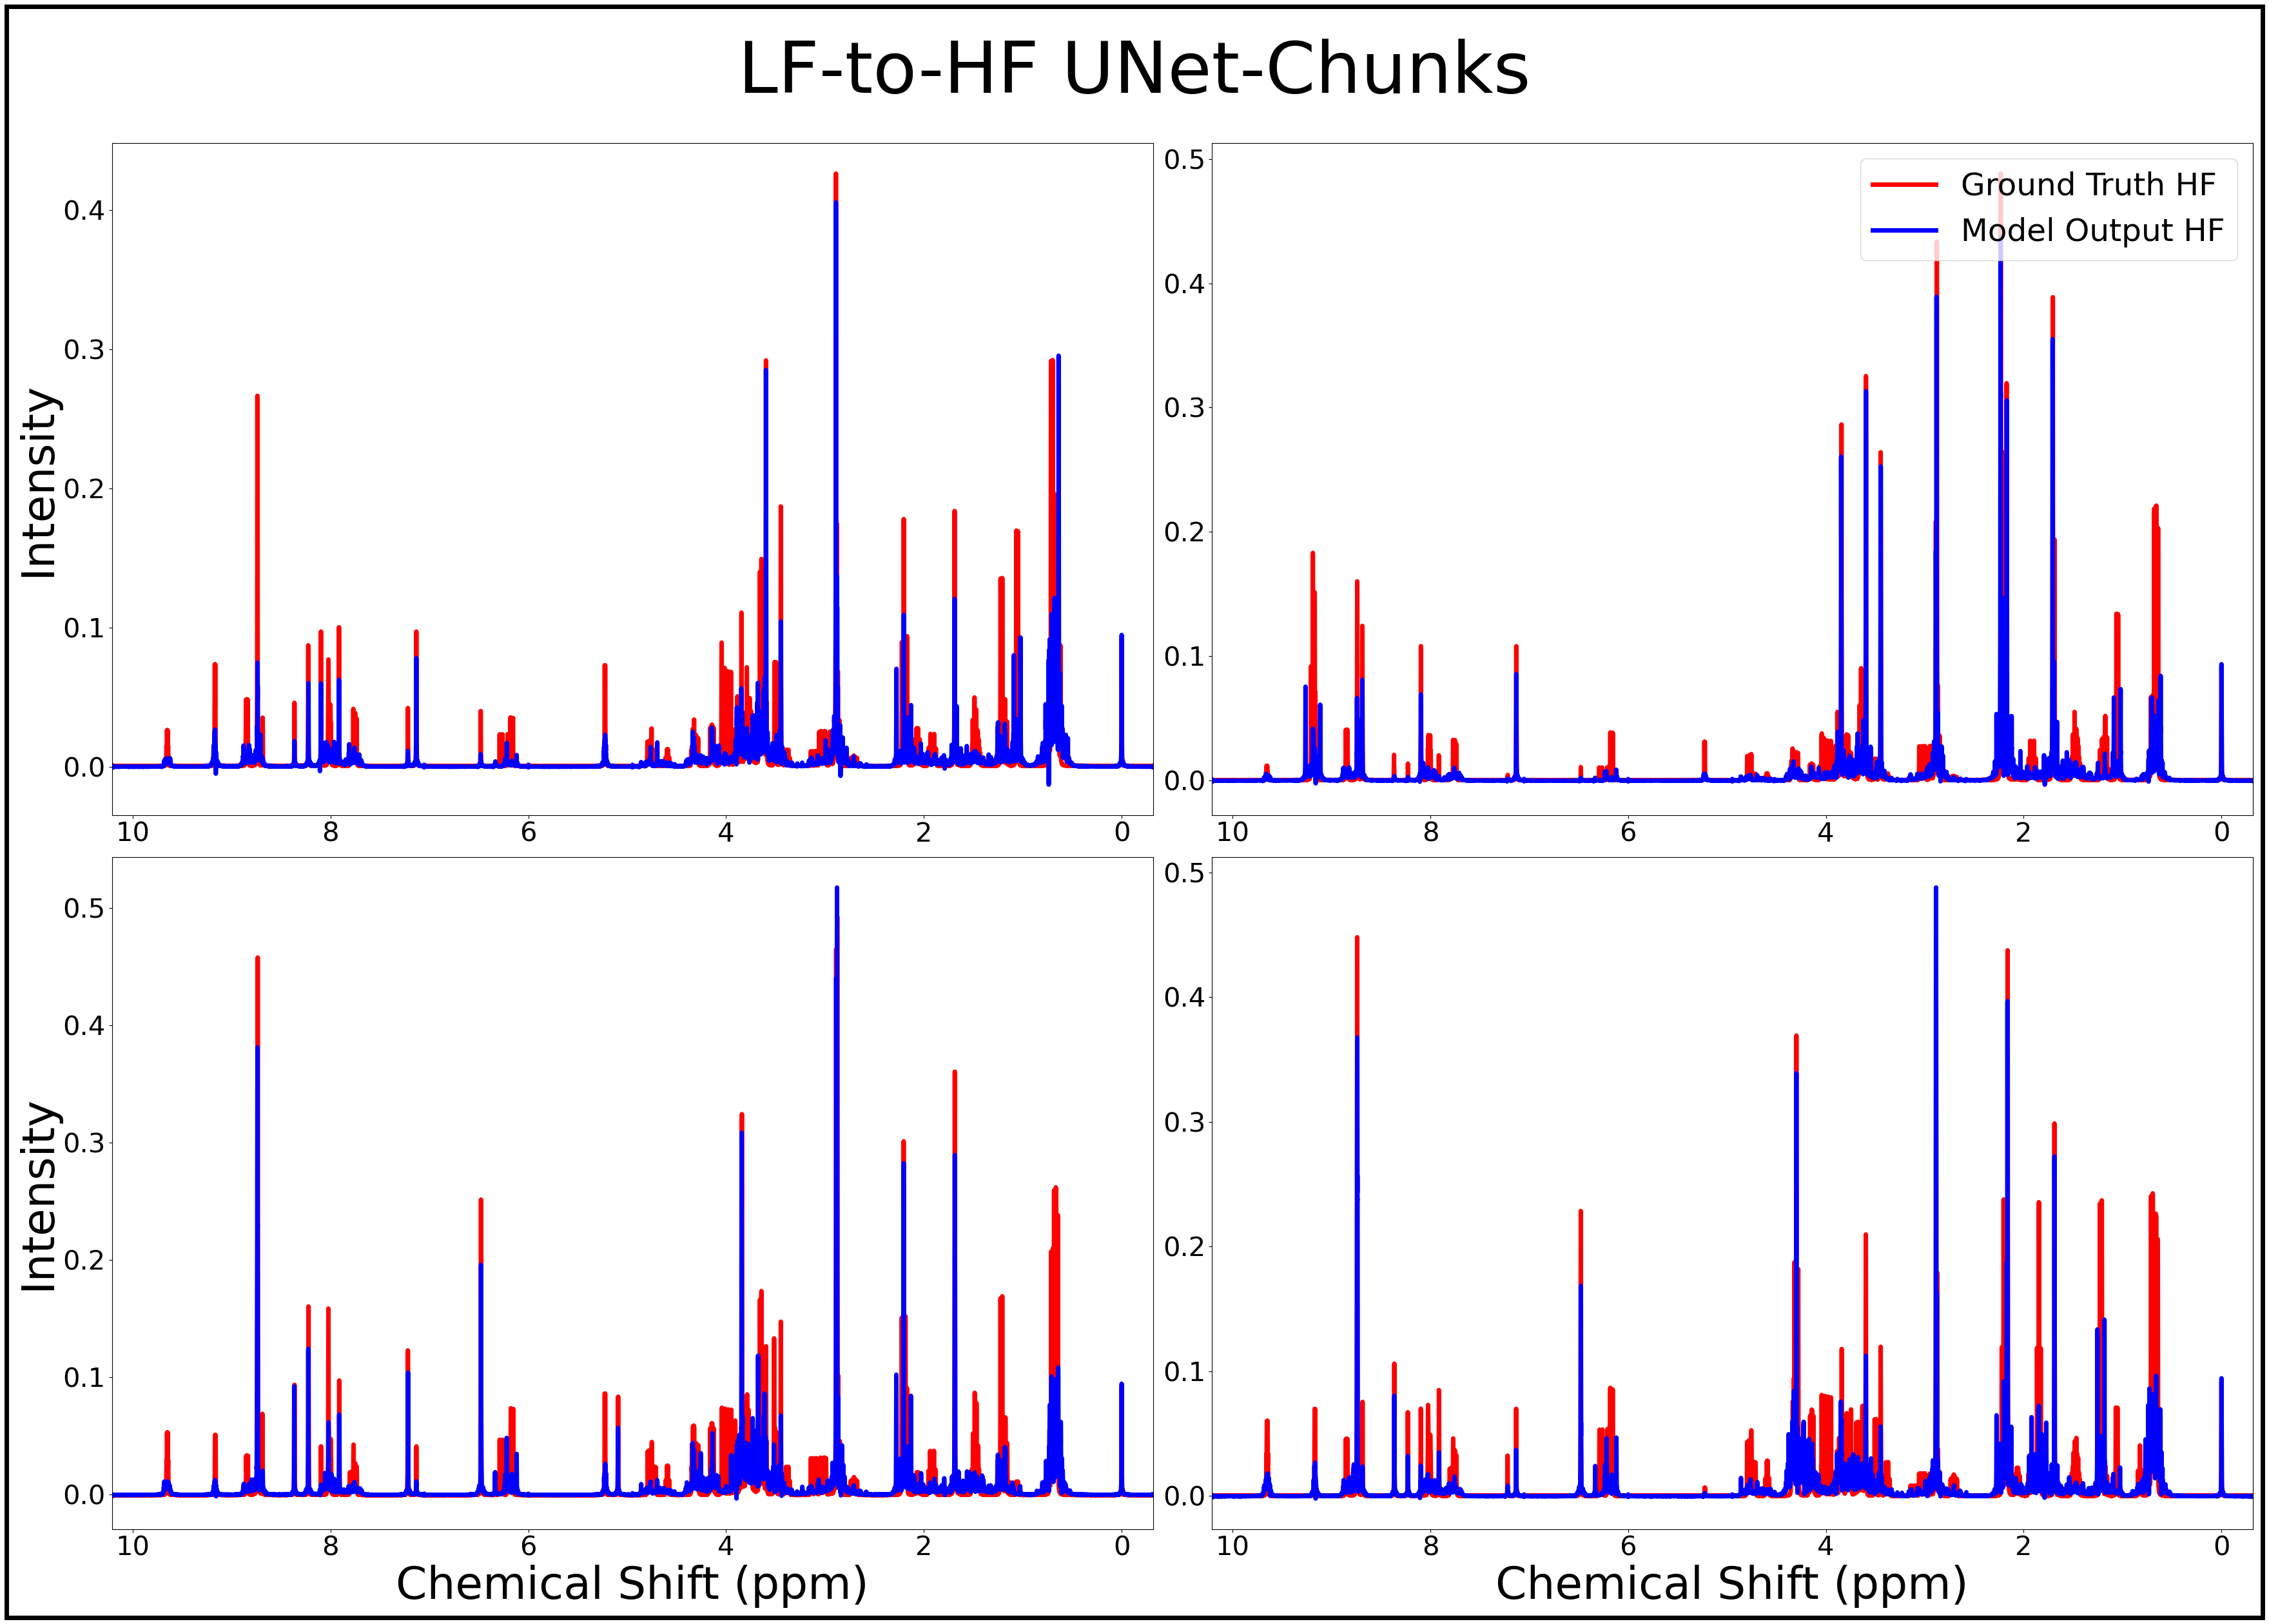

In [10]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF.unsqueeze(1)).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i][0], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])


    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF UNet-Chunks', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_UNet-Chunks.png', dpi=600, bbox_inches='tight')

plt.show()

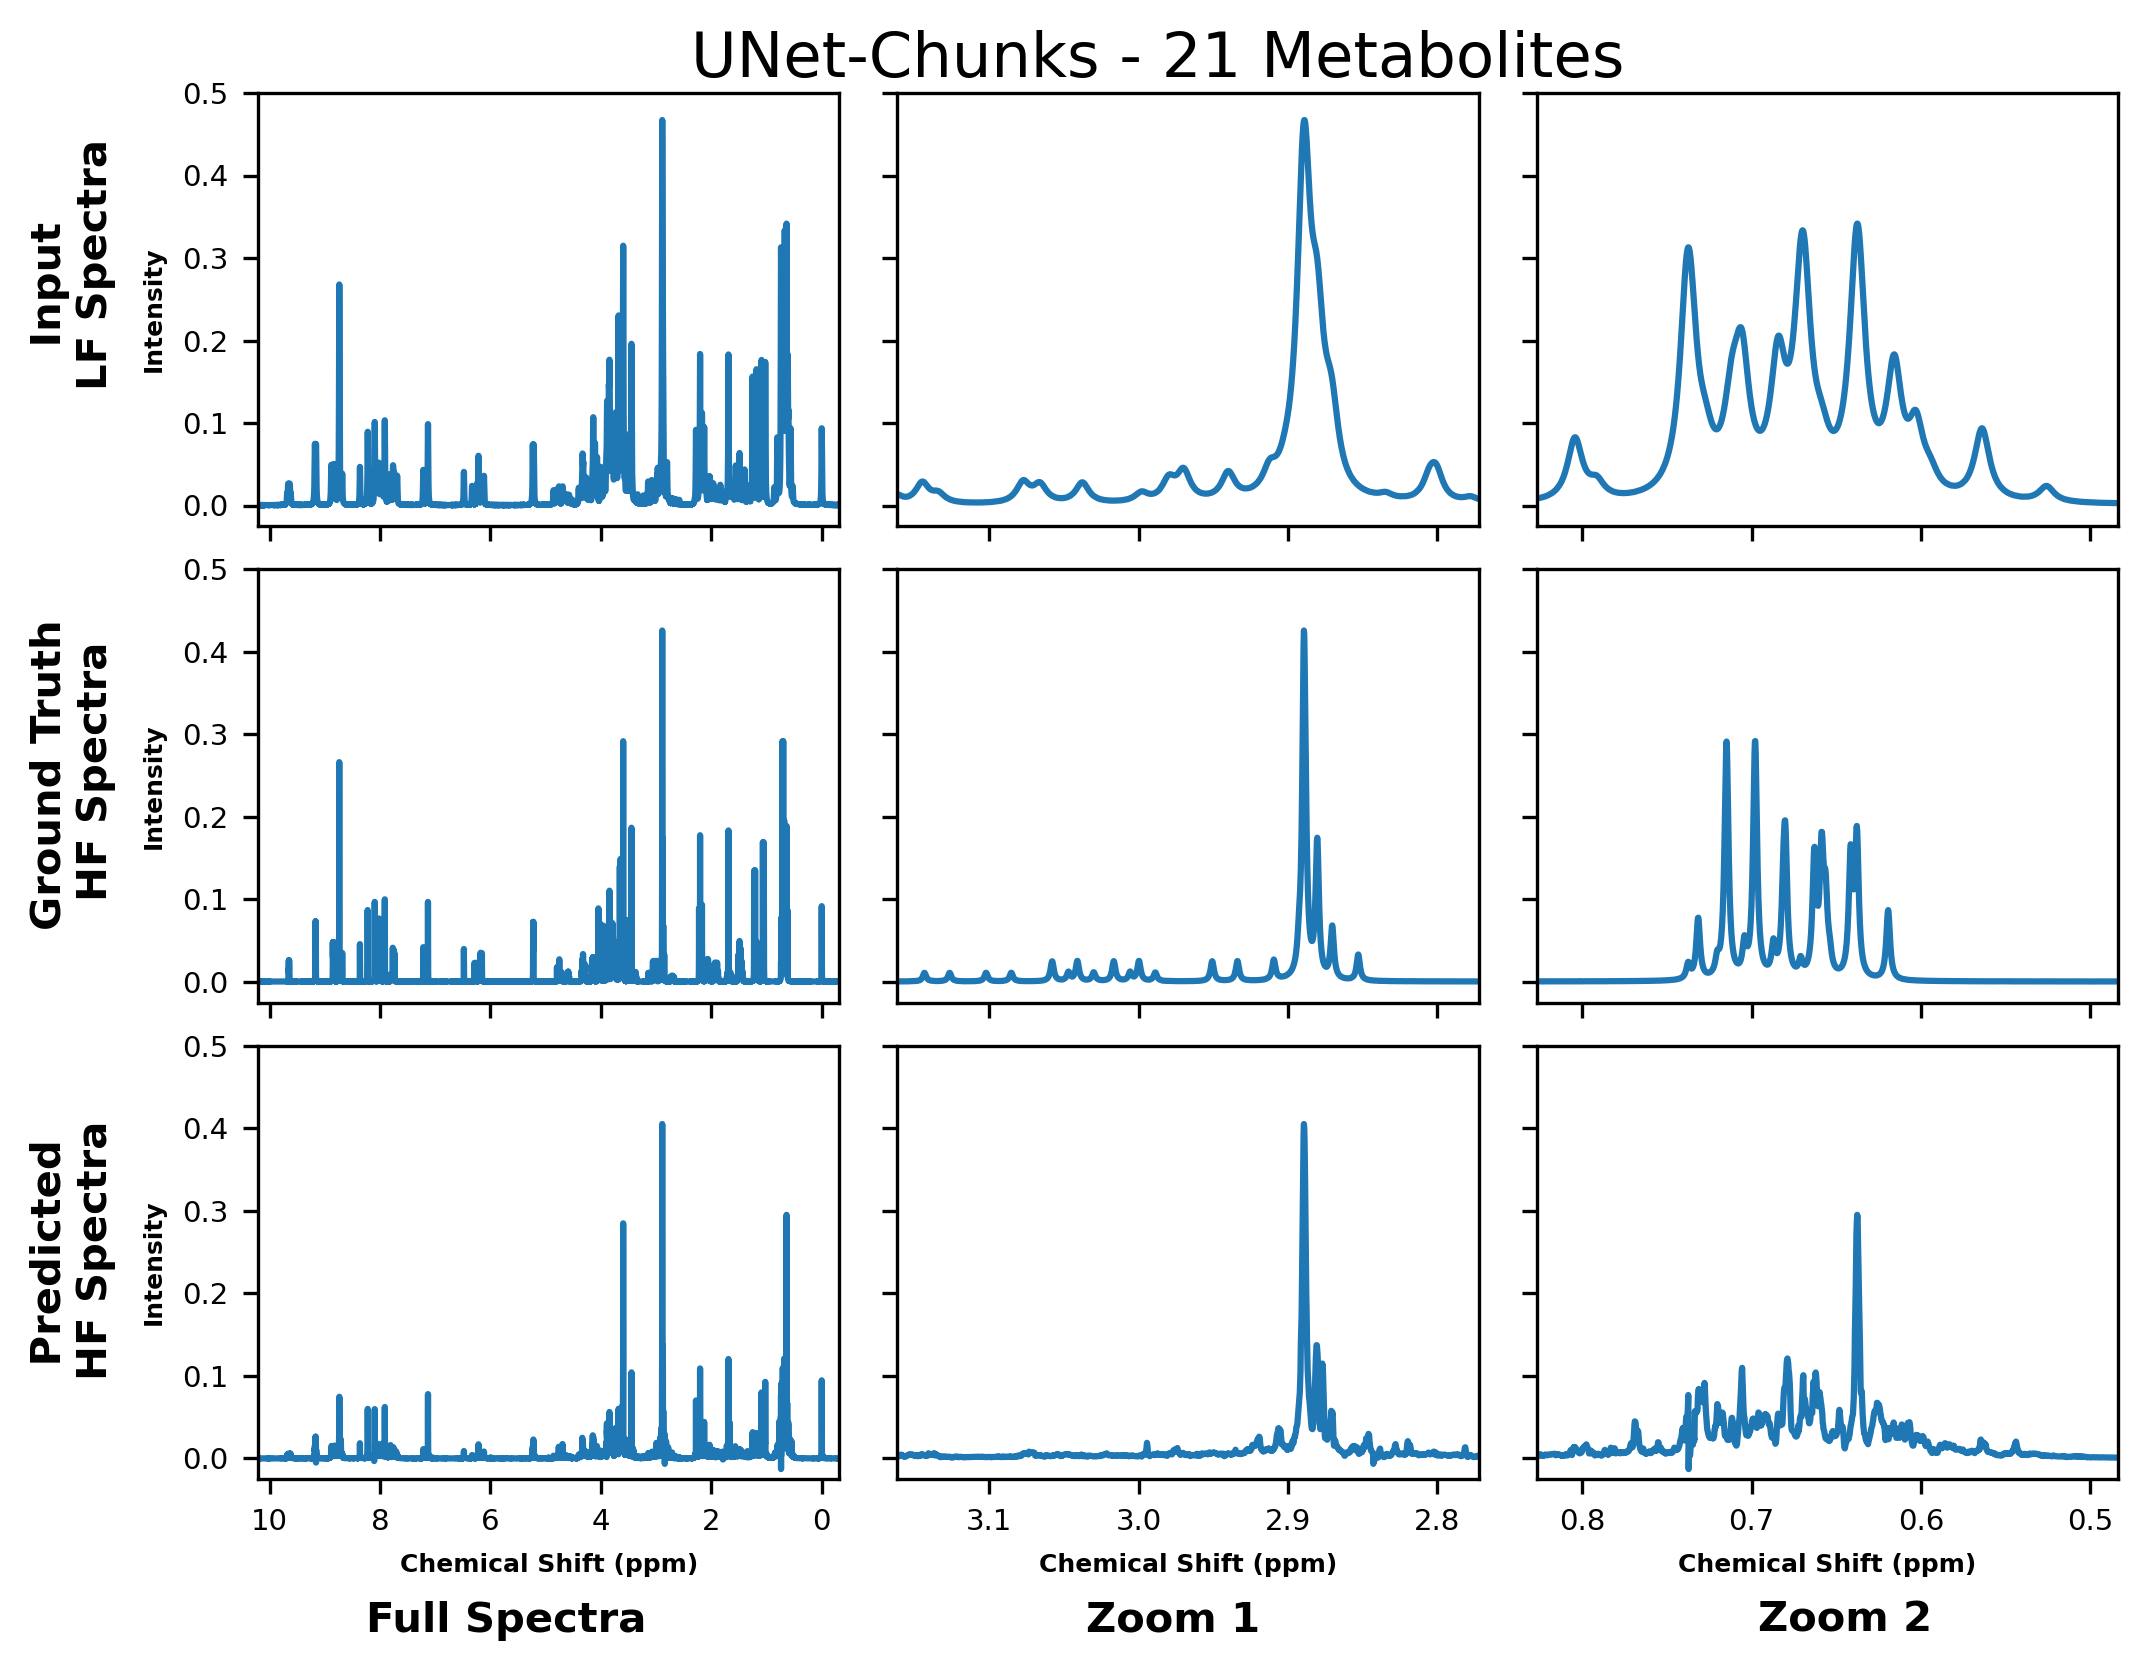

In [13]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')

# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space


# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.5)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.5)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.5)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.5)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.5)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.5)

axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.5)
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.5)
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.5)


# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('UNet-Chunks - 21 Metabolites', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('UNet-Chunks_Visual.png', dpi=600, bbox_inches='tight')

plt.show()


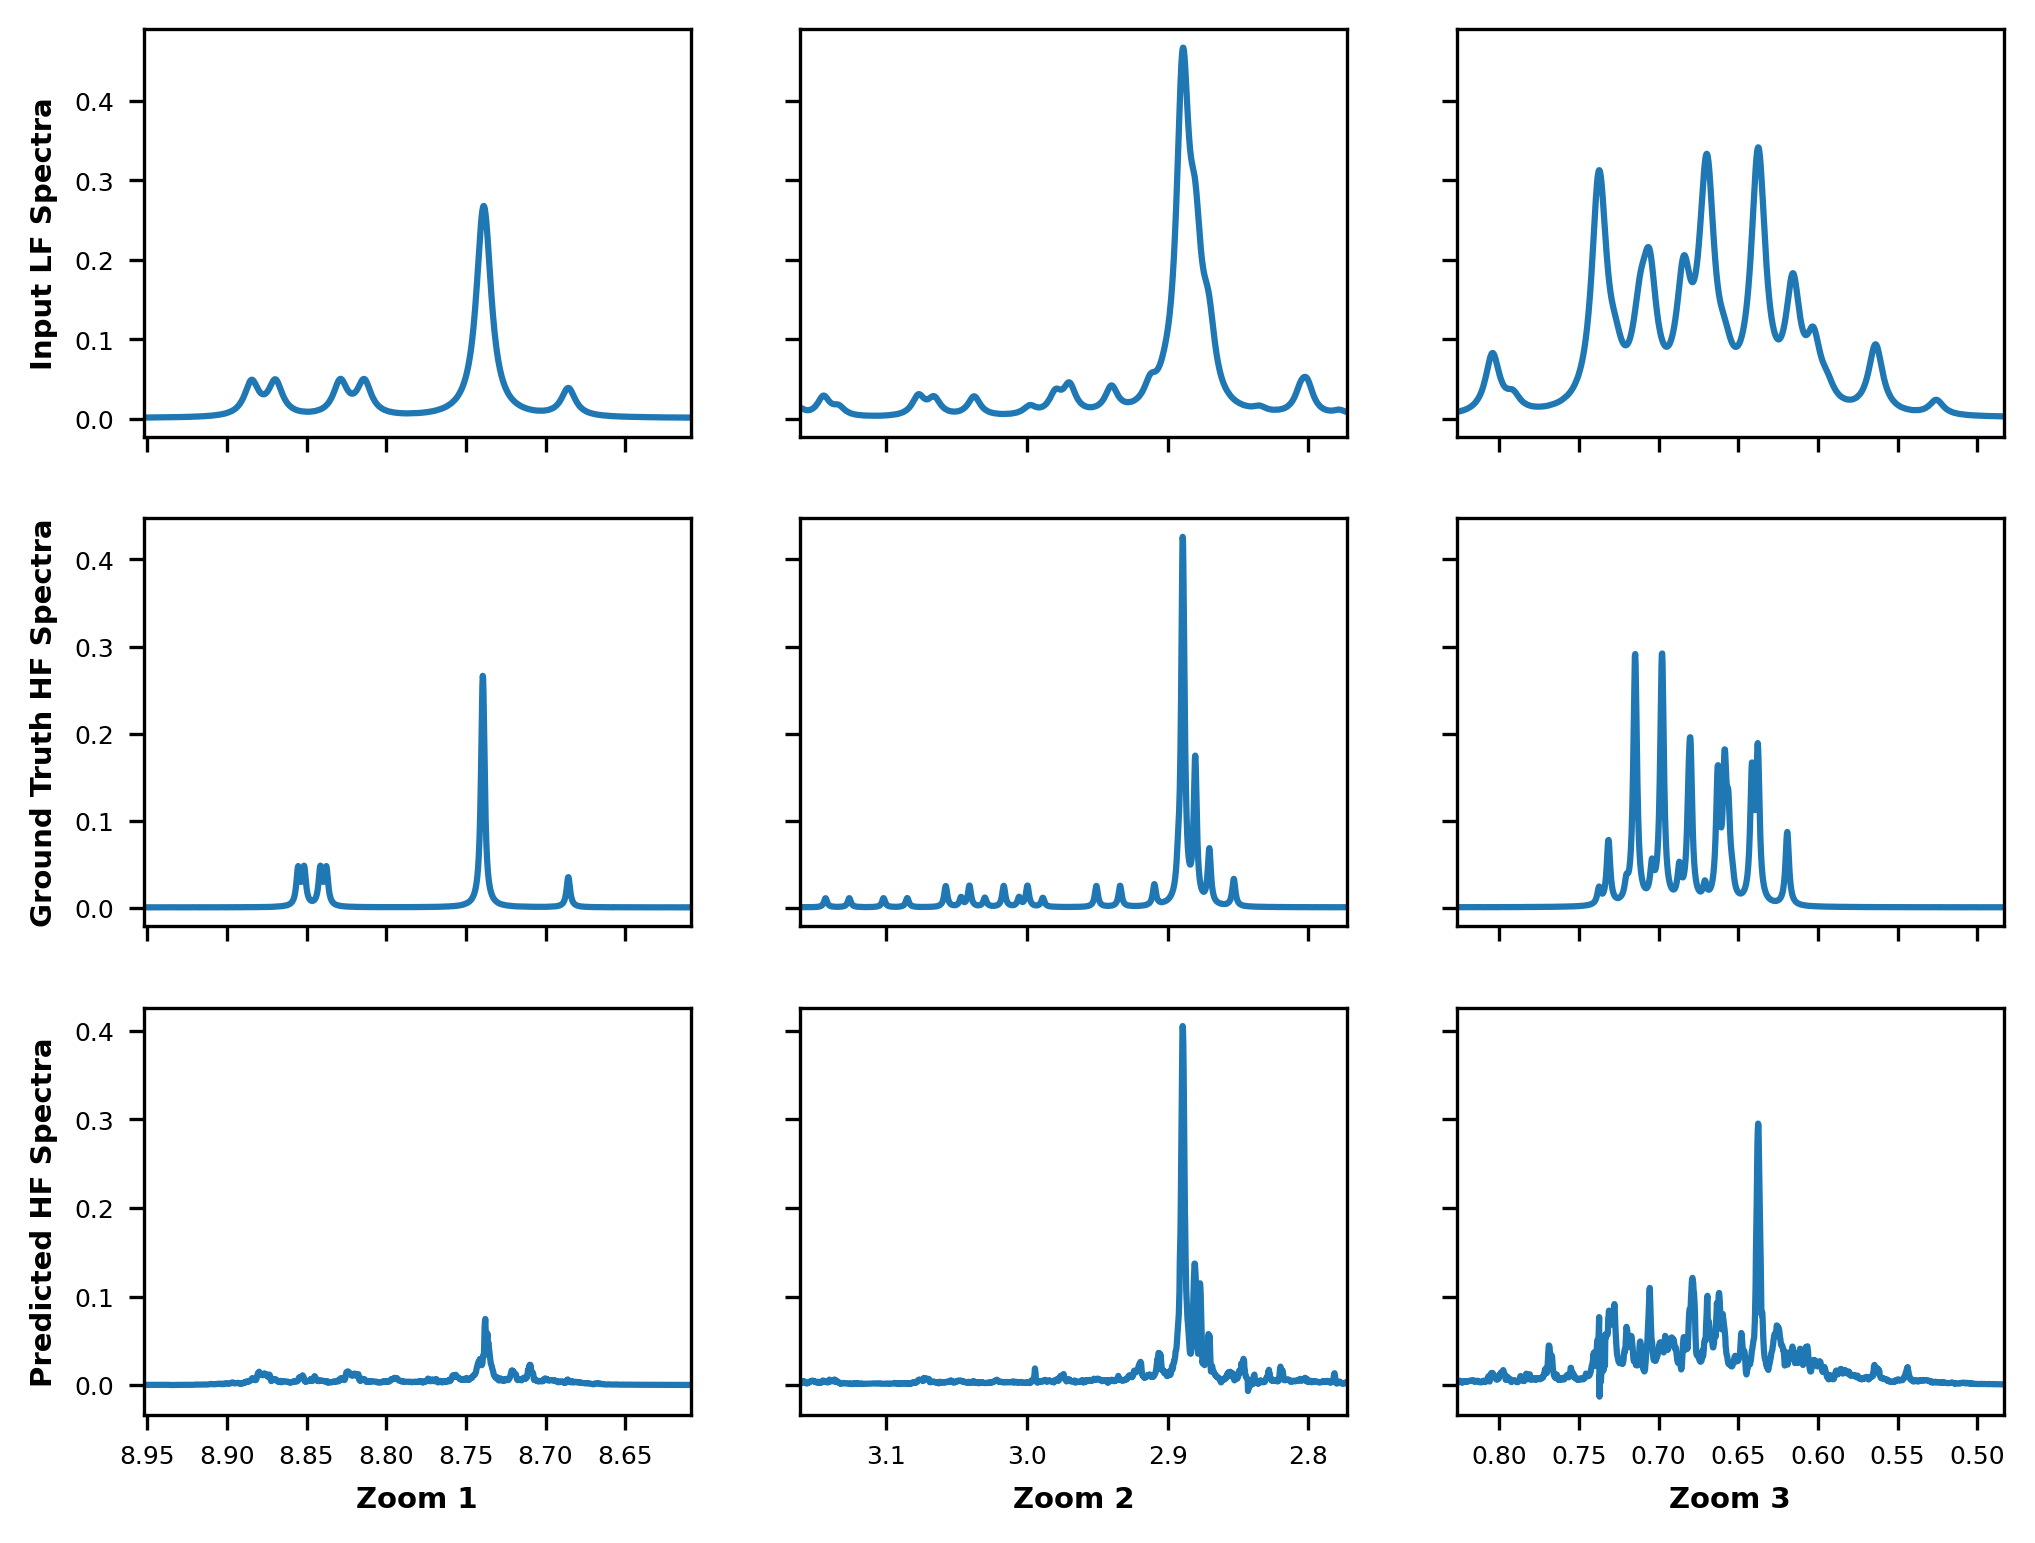

In [14]:
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5500],ppm[7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800],ppm[32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000],ppm[42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5500],ppm[7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800],ppm[32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000],ppm[42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[5500],ppm[7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[30800],ppm[32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41000],ppm[42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

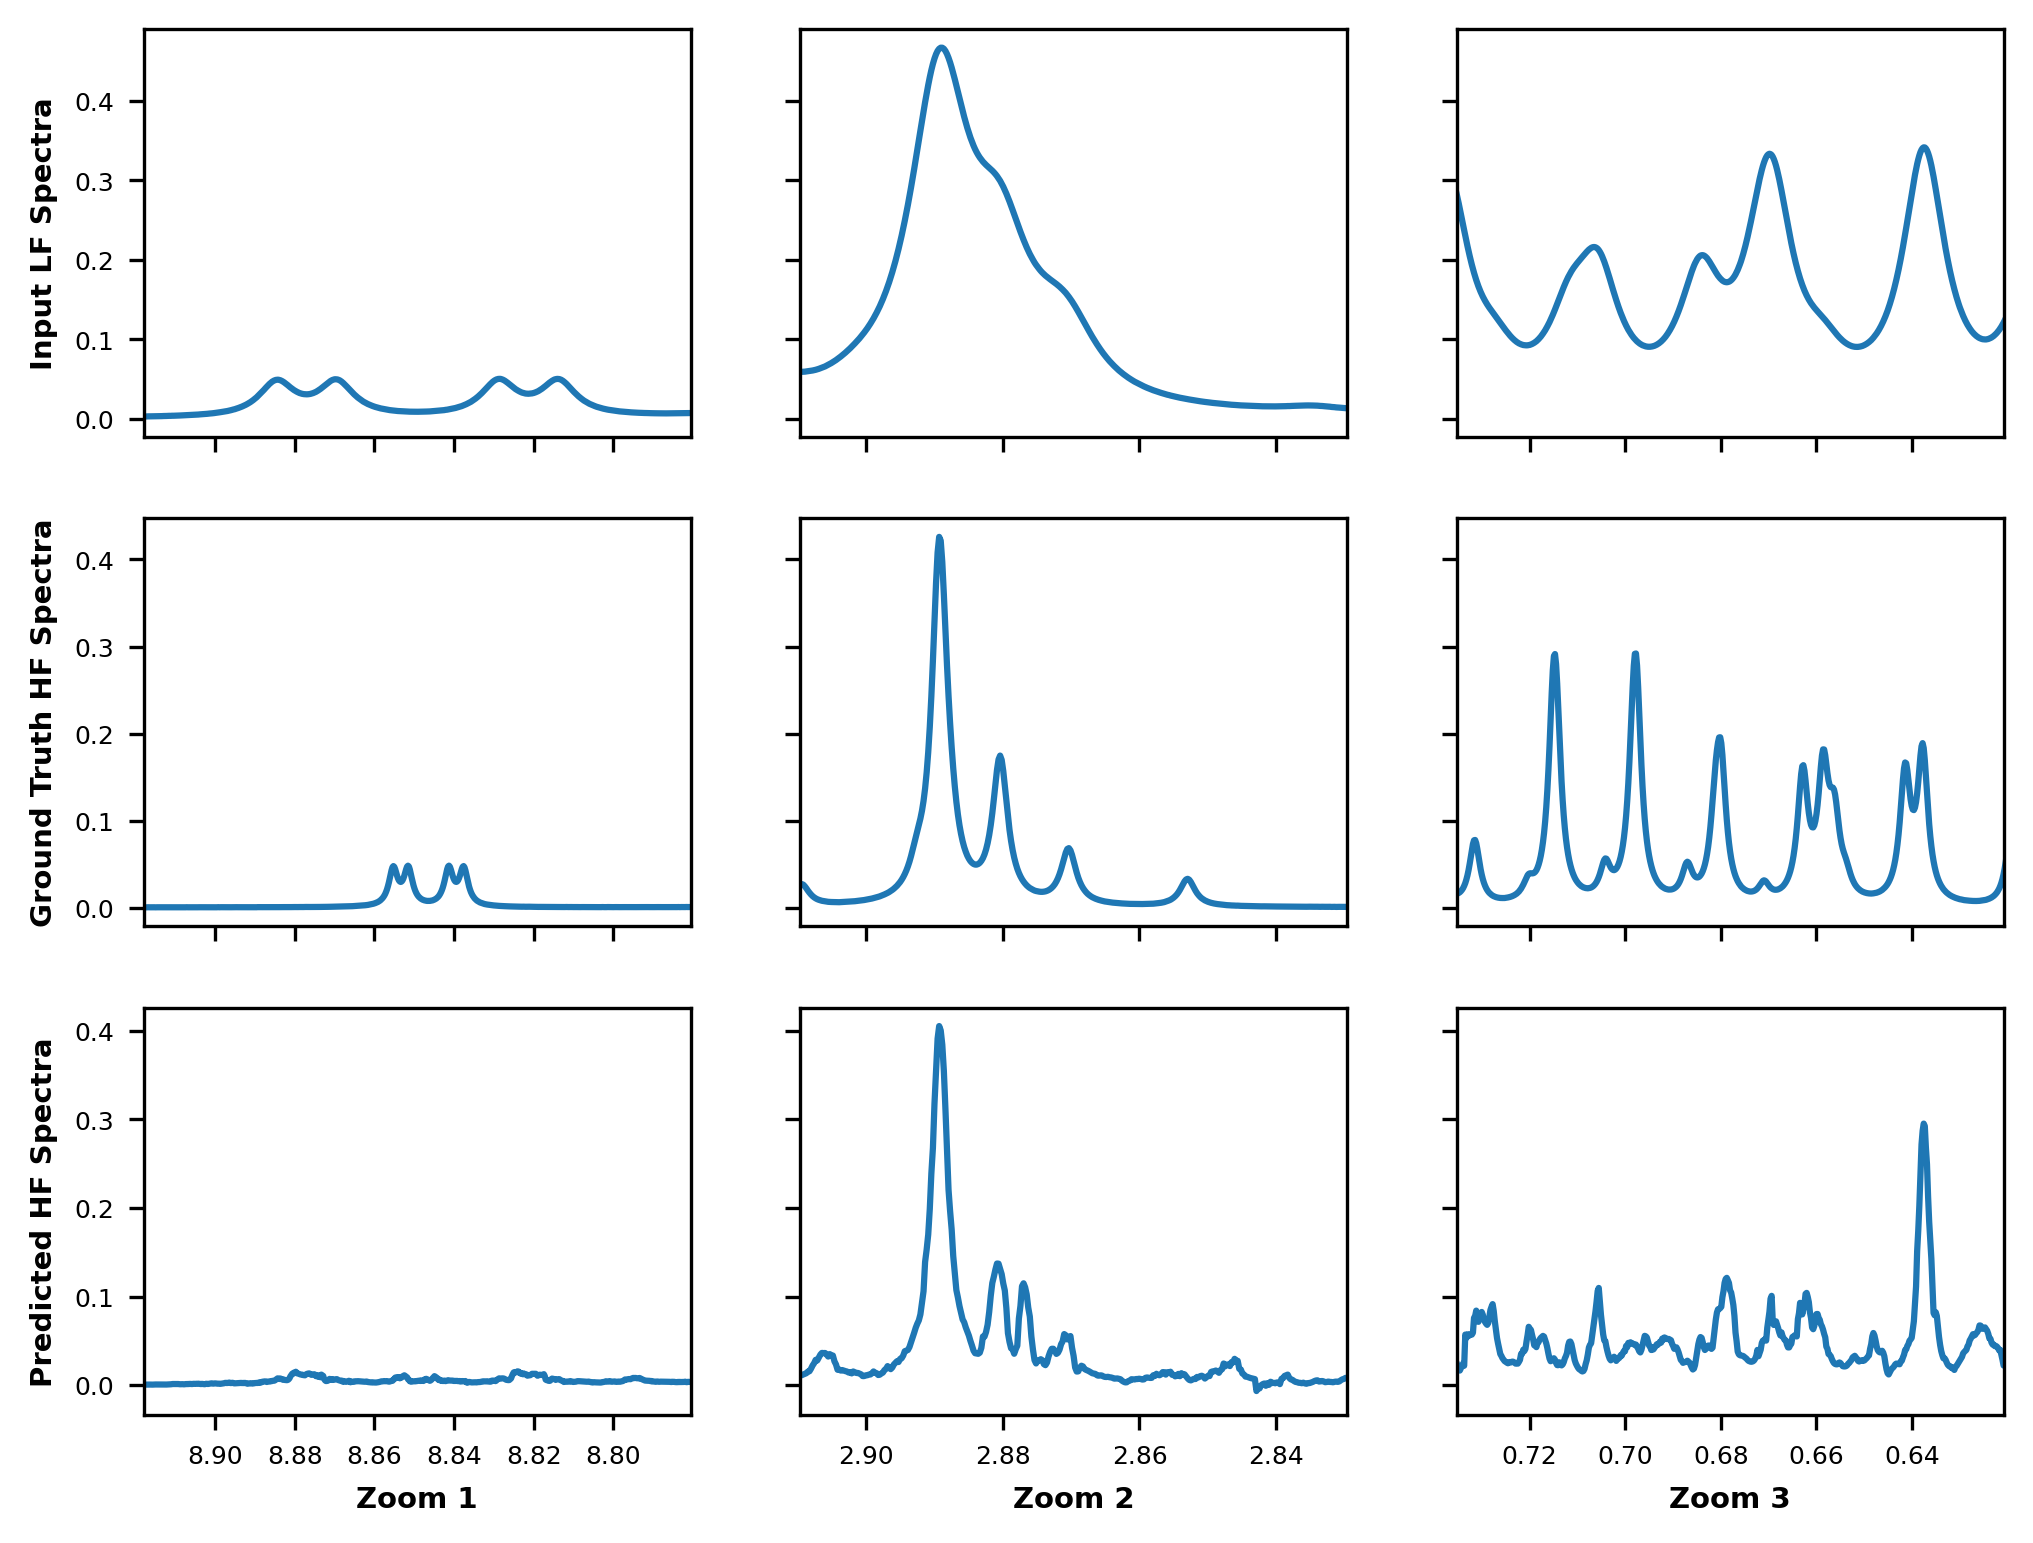

In [16]:
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5650],ppm[6250])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[31900],ppm[32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41400],ppm[41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5650],ppm[6250])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[31900],ppm[32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41400],ppm[41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[5650],ppm[6250])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[31900],ppm[32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41400],ppm[41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')